## Zadatak i problem

**COVID-19** (koronavirusna bolest 19, kovid, od engl. _**CO**rona**VI**rus **D**isease 20**19**_) zarazna je bolest izazvana virusom **SARS-CoV-2** (koronavirus teškog akutnog respiratornog sindroma 2, od engl. _**S**evere **A**cute **R**espiratory **S**yndrome **Co**rona**V**irus **2**_). Izazivač pripada grupi koronavirusa, kojima su prirodni rezervoar mnoge ptice i sisari. Konkretno, za SARS-CoV-2 je utvrđena najveća genetska sličnost sa koronavirusima prisutnim kod slepih miševa, pa se smatra da je upravo neki od tih virusa njegov prethodnik u evolucionom toku. Ipak, nije poznato da li je indeksni (prvi) ljudski slučaj zaraze povezan baš sa slepim miševima, ili sa nekim posrednikom, kako je to bilo sa ranijim, manje agresivnim **SARS-CoV**, za koji se smatra da je na čoveka prešao sa cibetke.

Prvi poznati slučaj zaraze potvrđen je u decembru 2019. u Vuhanu, glavnom i najvećem gradu pokrajine Hubej i uopšteno centralne Kine. Od tada se bolest proširila širom sveta, što je dovelo do **pandemije COVID-19**, koja je i u vreme pisanja ovog rada (maj 2021) uveliko u toku. Prvi slučaj u [**Republici Srbiji**](https://covid19.rs/) registrovan je 6. marta 2020, a do danas je od kovida obolelo preko 710.000 građana, od čega je preko 6.800 preminulo. Epidemija se odigrava u nekoliko **faza**, čija je **analiza i predviđanje** glavna tema ovog rada. Naime, kako u Srbiji, tako i u drugim državama, tok epidemije je iskazan **epidemijskom krivom**, koja se najčešće deli na **talase**, pri čemu se u okviru talasa smenjuju **uzlazna** i **silazna faza**. Pored njih, izdvajaju se posebni delovi kao što su **zdrava faza** (stanje između talasa), **pik** (vrh brda, prelaz uzlaznog toka u silazni), **plato** (zaravnjena kriva, umesto prethodnog), ali i mnogi drugi, u zavisnosti od autora.

Ideja rada je upotreba **skrivenih Markovljevih modela** (HMM) za modelovanje toka epidemije. Naime, prethodno opisane faze su **skrivena stanja**, dok poznati dnevni parametri poput broja novozaraženih i umrlih predstavljaju **sekvencijalna opažanja (opservacije, emisije)**. Na osnovu opaženih parametara, HMM je u mogućnosti da odredi najverovatniji niz odgovarajućih skrivenih stanja, pri čemu je poslednje stanje tekuće. Predviđeni niz stanja detaljno opisuje tok epidemije, dok se tekuće stanje može upotrebiti i u konkretne svrhe, kao što je planiranje **protivepidemijskih mera**, o čemu će biti reči u nastavku.

## Podaci i priprema

Podaci se dobavljaju pomoću biblioteke [*covid-daily*](https://github.com/alvarobartt/covid-daily). U pitanju je modul koji je sposoban da **automatski preuzme najnovije podatke** sa sajta [*Worldometer*](https://www.worldometers.info/coronavirus/), koristeći jednostavan veb-skrejper. Ovaj pristup je posebno pogodan jer ne zahteva lokalno čuvanje podataka, niti njihovo harkodiranje u svesci. Iako je u pitanju sajt koji je na početku epidemije kritikovan zbog pojedinih netačnih podataka, nema problema sa podacima o Srbiji – poklapaju se sa zvaničnim.

In [1]:
from covid_daily import data

Konkretno se koriste **tri osnovna parametra epidemije** – broj novozaraženih osoba, aktivnih slučajeva i umrlih potvrđenih pacijenata. Nakon vertikalnog spajanja, dakle po kolonama, podaci se mogu lepo prikazati i uporediti. Primetno je da sa brojem aktivnih slučajeva nema problema – celobrojnog je tipa i na početku su sve nule. Novozaraženi i umrli su, međutim, **drugačiji** – početne vrednosti su NaN (*not a number*), pa je i tip tih kolona suvišan realan. Inače, krajnji datum 25. maj 2021. fiksiran je kako bi se u nastavku dobili ponovljivi rezultati, nezavisno od dana i okolnosti pokretanja sveske u budućnosti.

In [2]:
import pandas as pd

df = pd.concat((data('serbia', 'graph-cases-daily'),
                data('serbia', 'graph-active-cases-total'),
                data('serbia', 'graph-deaths-daily')), axis=1)

df.columns = ['Novi', 'Aktivni', 'Umrli']

df = df.loc[:'2021-05-25']

df

,Novi,Aktivni,Umrli
Date,,,
2020-02-15,NaN,0,NaN
2020-02-16,NaN,0,NaN
2020-02-17,NaN,0,NaN
2020-02-18,NaN,0,NaN
2020-02-19,NaN,0,NaN
...,...,...,...
2021-05-21,391.0,17336,13.0
2021-05-22,404.0,16490,14.0
2021-05-23,266.0,15455,11.0


Naravno, razlika se bez problema prevazilazi **popunjavanjem nulama** i **promenom tipa**. Sada je sve u redu – celobrojne vrednosti sa početnim nulama. Na raspolaganju su, dakle tri celobrojne **vremenske serije**, sa datumima kao indeksima, koje govore najosnovnije o pandemiji COVID-19 u Republici Srbiji. Naravno, na osnovu ovih podataka po potrebi se mogu izračunati i kumulativni brojevi po svim parametrima, kao i broj oporavljenih. Dodatno se, uz poznati broj stanovnika, može proceniti i broj podložnih – onih za koje se smatra da nisu stekli imunitet, pa predstavljaju rezervoar za dalje širenje epidemije.

In [3]:
df.fillna(0, inplace=True)

df = df.astype(int)

df

,Novi,Aktivni,Umrli
Date,,,
2020-02-15,0,0,0
2020-02-16,0,0,0
2020-02-17,0,0,0
2020-02-18,0,0,0
2020-02-19,0,0,0
...,...,...,...
2021-05-21,391,17336,13
2021-05-22,404,16490,14
2021-05-23,266,15455,11


Štaviše, kako bi se naglasilo postojanje zdrave faze, moguće je **sleva popuniti skup nulama** npr. sve do Nove godine, što je i učinjeno.

In [4]:
import numpy as np

datumi = np.arange(np.datetime64('2020-01-01'),
                   np.datetime64('2020-02-14'))

dodatak = pd.DataFrame(np.zeros((len(datumi), 3), int),
                       index=datumi, columns=df.columns)

df = pd.concat((dodatak, df))

df

,Novi,Aktivni,Umrli
2020-01-01,0,0,0
2020-01-02,0,0,0
2020-01-03,0,0,0
2020-01-04,0,0,0
2020-01-05,0,0,0
...,...,...,...
2021-05-21,391,17336,13
2021-05-22,404,16490,14
2021-05-23,266,15455,11
2021-05-24,376,14429,11


## Prikaz podataka

Sređeni podaci mogu se lepo prikazati na graficima. Primetno je da raspodele **prilično sliče**. Jedina primetna razlika je u skali, pa je tako npr. broj aktivnih uglavnom znatno veći od broja novozaraženih, dok je broj umrlih znatno manji. Ipak, oblik raspodele je identičan. Ovo se uklapa u podatak da je udeo umrlih od svih zaraženih konstantno oko **1%**. Umrli i aktivni u suštini prate novozaražene, s tim što im je pik malo posle pika novozaraženih, što je isto očekivano.

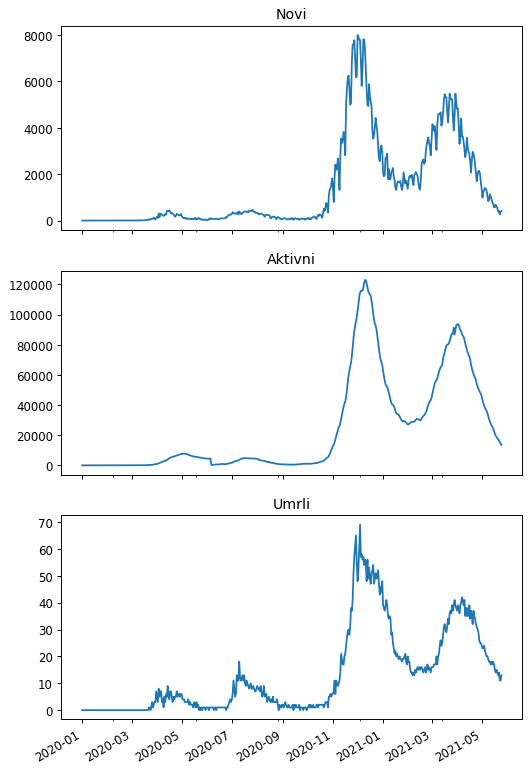

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 85

_, axs = plt.subplots(3, 1, figsize=(7, 12), sharex=True)

for i, ax in enumerate(axs):
    df.iloc[:, i].plot(ax=ax, title=df.columns[i], legend=False)

Podatke je moguće prikazati i zajedno, ali bez **skaliranja** se ne vidi mnogo toga. S njim je pak bolje uočljiva prethodna diskusija o tome da se podaci prate, ali se uočava i jedan izuzetak. Naime, u julu 2020. bilo je nesrazmerno mnogo smrti u odnosu na ostale parametre. Tada je stvarno i bio **najveći letalitet**.

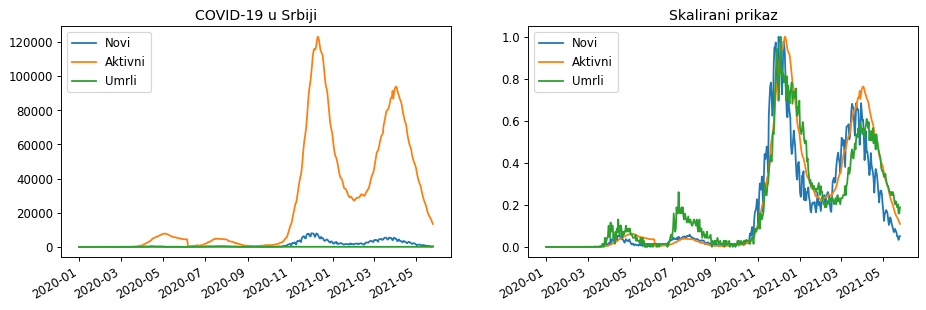

In [6]:
def skaliraj(df):
    df = df.copy()
    
    for col in df.columns:
        df[col] = df[col] / df[col].max()
    
    return df

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

df.plot(ax=ax1, title='COVID-19 u Srbiji')

skal = skaliraj(df)

_ = skal.plot(ax=ax2, title='Skalirani prikaz')

## Pomoćna klasa HMM

Za početak, biće korišćen **multinomijalni skriveni Markovljev model**, što je najprostiji diskretni HMM. Konkretno će, kako sada, tako i u nastavku, biti korišćena biblioteka [*hmmlearn*](https://github.com/hmmlearn/hmmlearn), specijalizovana za **nenadgledane sekvencijalne modele**. Modul čak otkriva baznu klasu, pa je lako nadogradiv. U nastavku je implementirana pomoćna klasa koja će nadalje služiti za lakši rad sa klasama iz biblioteke – prvo za sâmo modelovanje, a zatim i za prikaz rezultata.

In [7]:
from matplotlib.ticker import NullLocator

class HMM:
    def __init__(self, model, **kwargs):
        self.model = model(random_state=0, **kwargs)
    
    def modeluj(self, podaci, metod):
        if hasattr(podaci, 'values'):
            podaci = podaci.values
        
        metod = getattr(self.model, metod)
        
        try:
            return metod(podaci)
        except:
            return metod(podaci.reshape(-1, 1))
    
    def fit(self, podaci):
        self.modeluj(podaci, 'fit')
        self.pred = self.predict(podaci)
        return self
    
    def refit(self, podaci):
        self.pred = self.predict(podaci)
        return self
    
    def predict(self, podaci):
        return self.modeluj(podaci, 'predict')
    
    def opis(self):
        print('Broj simbola:', self.model.n_features)
        print('Broj skrivenih stanja:', self.model.n_components)
        
        if hasattr(self.model, 'n_mix'):
            print('Broj mešavina:', self.model.n_mix)
        print()
        
        print('Polazne verovatnoće:')
        print(self.model.startprob_)
        print()
        
        print('Matrica prelaza:')
        print(self.model.transmat_)
        print()
        
        if hasattr(self.model, 'emissionprob_'):
            print('Matrica emisija:')
            print(self.model.emissionprob_)
        else:
            print('Srednje vrednosti:')
            print(self.model.means_)
            print()
            
            print('Kovarijanse:')
            print(self.model.covars_)
    
    def start(self, start):
        self.model.startprob_ = np.array(start)
    
    def trans(self, trans):
        self.model.transmat_ = np.array(trans)
    
    def emiss(self, emiss):
        self.model.emissionprob_ = np.array(emiss)
    
    def plot_prep(self, podaci, ax=None, **kwargs):
        if ax is None:
            ax = plt.gca()
        
        podaci.plot(ax=ax, **kwargs)
        
        klasa = self.model.__class__.__name__
        multi = klasa.startswith('M')
        kovar = '' if multi else f' ({self.model.covariance_type})'
        
        ax.set_title(f'{klasa}{kovar} ― {podaci.name.lower()}')
        
        ax.xaxis.set_minor_locator(NullLocator())
        
        if not hasattr(self, 'pred'):
            self.fit(podaci)
        
        return ax
    
    def plot(self, podaci, boje=None, leg=None, ax=None, ll=True, **kwargs):
        ax = self.plot_prep(podaci, ax, **kwargs)
        
        if leg is None:
            leg = boje if boje else range(self.model.n_components)
        
        if boje is None:
            np.random.seed(0)
            boje = [np.random.rand(3,) for _ in range(self.model.n_components)]
        
        i = 0
        for j in range(1, len(podaci)):
            if self.pred[j] != self.pred[i]:
                ax.axvspan(podaci.index[i], podaci.index[j],
                           alpha=0.4, color=boje[self.pred[i]])
                i = j
        
        ax.axvspan(podaci.index[i], podaci.index[j],
                   alpha=0.4, color=boje[self.pred[i]])
        
        legs = []
        
        for b, l in zip(boje, leg):
            legs.append(ax.axvspan(podaci.index[i], podaci.index[i],
                                   alpha=0.4, color=b, label=l))
        
        if leg and ll:
            ax.legend(legs, leg,
                      title='Ključ', loc=(1.1, 0.4 - 0.035*self.model.n_components),
                      fontsize=12, title_fontsize=12)
        elif leg and not ll:
            ax.legend(legs, leg, title='Ključ')
    
    def plot_activity(self, podaci, mere=[], ax=None):
        ax = self.plot_prep(podaci, ax)
        
        boje = ['y', 'r', 'g']
        
        if podaci[0] == podaci[1]:
            b = 0
        elif podaci[0] < podaci[1]:
            b = 1
        else:
            b = 2
        
        leg = ['plato', 'rast', 'pad']
        leg = [*leg[:b], *leg[b:]]
        
        i = 0
        for j in range(1, len(podaci)):
            if self.pred[j] != self.pred[i]:
                if self.pred[i] == 1:
                    ax.axvspan(podaci.index[i], podaci.index[j],
                               alpha=0.4, color=boje[0])
                    
                    b = 'r'
                else:
                    k = i + np.argmax(podaci[i:j])
                    
                    ax.axvspan(podaci.index[i], podaci.index[k],
                               alpha=0.4, color=boje[1])
                    
                    ax.axvspan(podaci.index[k], podaci.index[j],
                               alpha=0.4, color=boje[2])
                    
                    b = 'y'
                
                i = j
        
        ax.axvspan(podaci.index[i], podaci.index[j],
                   alpha=0.4, color=b)
        
        legs = []

        for b, l in zip(boje, leg):
            legs.append(ax.axvspan(podaci.index[i], podaci.index[i],
                                   alpha=0.4, color=b, label=l))
        
        for mera in mere:
            ax.axvline(mera, dashes=(3.1,), color='black')
        
        if mere:
            legs.append(*ax.plot([], [], dashes=(3.1,), color='black'))
        
        ax.legend(legs, [*leg, 'mere'],
                  title='Ključ', loc=(1.1, 0.4 - 0.035*self.model.n_components),
                  fontsize=12, title_fontsize=12)
    
    def plot_change(self, podaci, mere=[], ax=None):
        ax = self.plot_prep(podaci, ax)
        
        boje = ['r', 'orange', 'g', 'y']
        
        if podaci[0] == podaci[1]:
            b = 3
        elif podaci[0] < podaci[1]:
            b = 0
        else:
            b = 2
        
        leg = ['rast', 'pik', 'pad', 'plato']
        leg = [*leg[:b], *leg[b:]]
        
        i = 0
        for j in range(1, len(podaci)):
            if self.pred[j] != self.pred[i]:
                ax.axvspan(podaci.index[i], podaci.index[j],
                           alpha=0.4, color=boje[b])
                b = (b + 1) % len(boje)
                i = j
        
        ax.axvspan(podaci.index[i], podaci.index[j],
                   alpha=0.4, color=boje[b])
        
        legs = []

        for b, l in zip(boje, leg):
            legs.append(ax.axvspan(podaci.index[i], podaci.index[i],
                                   alpha=0.4, color=b, label=l))
        
        for mera in mere:
            ax.axvline(mera, dashes=(3.1,), color='black')
        
        if mere:
            legs.append(*ax.plot([], [], dashes=(3.1,), color='black'))
        
        ax.legend(legs, [*leg, 'mere'],
                  title='Ključ', loc=(1.1, 0.4 - 0.035*self.model.n_components),
                  fontsize=12, title_fontsize=12)
    
    def plot_pprep(self, args):
        broj = []
        
        j = 0
        for i in range(1, len(self.pred)):
            if self.pred[i-1] != self.pred[i]:
                broj.append(i-j)
                
                j = i
        
        broj.append(i-j+1)
        
        i = 0
        for arg in args:
            broj[i] = sum(broj[i:i+arg])
            
            del broj[i+1:i+arg]
            
            i += 1
        
        return i, broj
    
    def plot_parts(self, podaci, *args):
        i, broj = self.plot_pprep(args)
        
        pred = self.pred
        
        self.pred = [i for i in range(len(broj)) for j in range(broj[i])]
        
        n = self.model.n_components
        
        self.model.n_components = i
        
        self.plot(podaci, leg=[f'faza {j+1}' for j in range(i)])
        
        self.pred = pred
        
        self.model.n_components = n
    
    def plot_waves(self, podaci, *args):
        argss = []
        
        for arg in args:
            argss.extend([1, arg])
        
        i, broj = self.plot_pprep(argss)
        
        pred = self.pred
        
        self.pred = [i for i in range(len(broj)) for j in range(broj[i])]
        
        leg = []
        
        for j in range(i):
            leg.extend([f'pauza {j}', f'talas {j+1}'])
        
        leg[0] = 'zdravo'
        
        ax1, ax2 = grafici(2)
        
        n = self.model.n_components
        
        self.model.n_components = i
        
        self.plot(podaci, leg=leg, ax=ax2)
        
        self.pred = [j if not j else j%2 + 2 * (not j%2) for j in self.pred]
        
        self.model.n_components = 3
        
        self.plot(podaci, ['g', 'r', 'y'], ['zdravo', 'talas', 'pauza'], ax=ax1)
        
        self.pred = pred
        
        self.model.n_components = n

## Naivni diskretni HMM

Najnaivniji mogući model napravljen je korišćenjen **neizmenjenih** podataka o **umrlim** potvrđenim pacijentima. Naime, celi brojevi su diskretni, a kako nije bilo više od 69 umrlih u jednom danu, opseg vrednosti je konačan i prilično mali. Zahtevana su samo dva **skrivena stanja**, koja bi se eventualno mogla protumačiti kao povišena i normalna aktivnost. Iz **polaznih verovatnoća** vidi se da je model ispravno zaključio da se skoro sigurno polazi iz normalnog stanja. Iz **matrice prelaza** vidi se da je zaključak da se stanje menja vrlo retko, u proseku jednom u mesečak dana. **Matrica emisija** govori o verovatnoći da neko stanje emituje određeni broj mrtvih. Po njoj se vidi da se model ipak **ne ponaša očekivano**, jer u pretpostavljenom normalnom stanju ima dosta smrti.

In [8]:
from hmmlearn.hmm import MultinomialHMM

model = HMM(MultinomialHMM, n_components=2).fit(df['Umrli'])

model.opis()

Broj simbola: 70
Broj skrivenih stanja: 2

Polazne verovatnoće:
[4.05404913e-23 1.00000000e+00]

Matrica prelaza:
[[0.96936711 0.03063289]
 [0.0229424  0.9770576 ]]

Matrica emisija:
[[1.54250257e-09 1.05846040e-02 8.25051767e-03 1.12495936e-01
  6.48247160e-02 9.47440609e-02 6.98114133e-02 5.48518247e-02
  4.48787657e-02 4.48787657e-02 2.49326476e-02 5.48517196e-02
  9.97305904e-03 2.15566360e-02 7.51828580e-03 4.14373130e-06
  8.18926836e-09 4.91252879e-02 4.48786757e-02 3.49057066e-02
  4.98652952e-02 3.49057066e-02 9.97305904e-03 1.49595886e-02
  2.49326476e-02 1.99461181e-02 9.97305904e-03 4.98652952e-03
  1.49456642e-02 1.99461181e-02 1.49595885e-02 1.97628841e-02
  7.36552661e-03 0.00000000e+00 3.70505797e-04 3.66640067e-10
  2.78117357e-10 8.20341570e-10 4.09318514e-05 1.86297471e-12
  5.09285291e-14 9.33541969e-13 2.62386441e-14 2.70785385e-16
  2.86395359e-15 0.00000000e+00 4.98693197e-16 3.42508666e-15
  2.04255679e-13 4.03476963e-14 0.00000000e+00 3.32353347e-14
  1.1793445

Model je još bolje opisan svojom **ilustracijom**. U konkretnom slučaju, zelena boja predstavlja pretpostavljeno relativno normalno stanje, dok crvena boja predstavlja pretpostavljenu povišenu aktivnost virusa. Čini se da je u prvoj polovini epidemije, do jeseni 2020, stvarno tako. Nadalje, međutim, izgleda kao da su stanja zamenila mesta. Šta se dogodilo? Problem je što su ulaz za diskretni HMM konkretni brojevi umrlih, koji su **suštinski neprekidni**. Model stoga nije mogao da dobro uhvati nepostojeću diskretnu raspodelu, pa je prosto naučio brojeve napamet. Konkretno je u prvoj polovini epidemije naučio brojeve koji se podvode pod povišenu aktivnost, pa u drugoj polovini za normalnu proglašava sve koji nisu u tom opsegu (zapravo skupu, jer on ni ne vidi opseg), uključujući veće. Iako je to kontraintuitivno, pošto čovek makar podsvesno zna da su brojevi umrlih kontinualni, korišćeni model to ne može da razume, budući diskretan. Nešto manje uočljivo ograničenje ovog modela jeste to da na ume da radi sa neviđenim vrednostima. Ukoliko bi se pojavio dan sa više od 69 umrlih, predviđanje skrivenog stanja ne bi uspelo. Isto bi se dogodilo ukoliko bi se model *trenirao* samo na prvoj polovini skupa, a testirao i na drugoj.

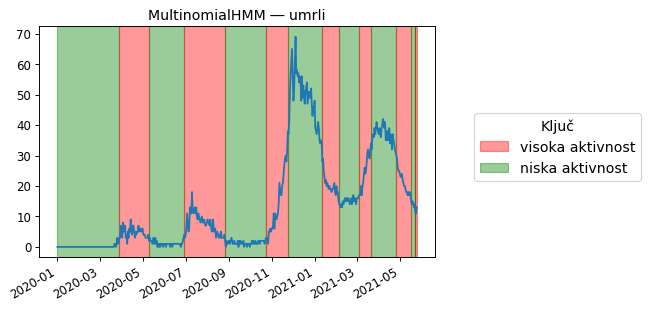

In [9]:
model.plot(df['Umrli'], ['r', 'g'], ['visoka aktivnost', 'niska aktivnost'])

Uprkos svim ograničenjima i velikoj naivnosti, ovakav model ipak se može pohvaliti za **relativno dobar uspeh u prvoj polovini** epidemije u Srbiji. Kako se vidi iz priloženog, ne samo da ga nije *prevario* neobičan pad smrtnosti početkom aprila (kriva je nakratko pala, ali se kroz nekoliko dana još više uzdigla, što je model uspešno predvideo kao konstantno visoku aktivnost virusa), već je krajem oktobra uspešno predvideo novi talas zaraze (uski crveni deo sasvim desno na grafiku), iako broj umrlih nije nešto značajno skočio. Ovaj uspeh daje nadu da će napredniji modeli biti još boljih performansi.

In [10]:
print(df['Umrli'].loc['2020-10-15':'2020-11-7'].to_numpy())

[ 2  2  2  2  2  2  1  2  3  3  3  1  5  5  6  5  6  6  7 11  6 11 10  9]


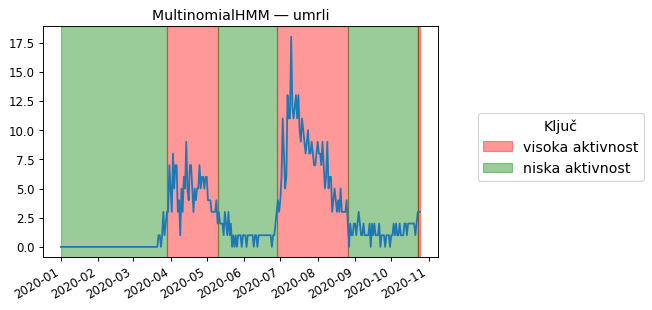

In [11]:
umrli = df['Umrli'].loc[:'2020-10-25']

model = HMM(MultinomialHMM, n_components=2).fit(umrli)

model.plot(umrli, ['r', 'g'], ['visoka aktivnost', 'niska aktivnost'])

Visoka aktivnost može se prema **maksimumu (piku)** podeliti na **uzlaznu** i **silaznu fazu**, što daje jednostavan opisni model, kao u nastavku. Moguće je na grafiku prikazati i protivepidemijske mere, o čemu će detaljnije biti reči kasnije. Naravno, kako se oslanja na mogućnost izračunavanja maksimuma unutar faze sa visokom aktivnošću, ovaj model ne može služiti za planiranje ili precizni prikaz epidemije kada je u toku visoka aktivnost, jer se tad ne zna tačan pik.

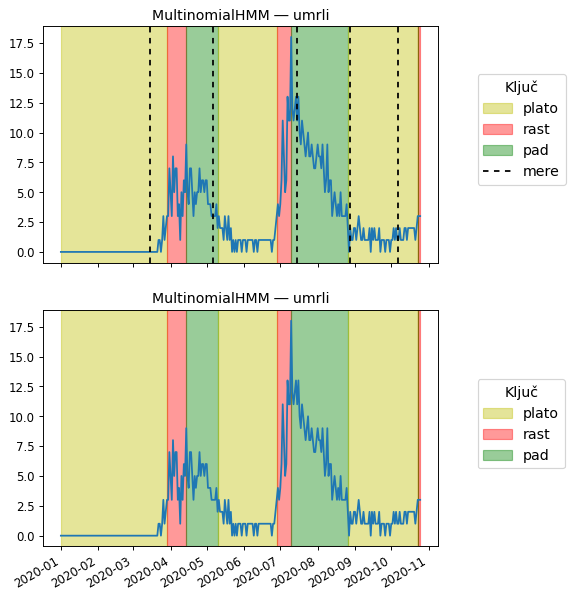

In [12]:
grafici = lambda n, k=1, sx='col', sy='row': \
                 plt.subplots(n, k, figsize=(6*k, 4.5*n),
                              sharex=sx, sharey=sy)[1]

mere = ['2020-03-15', # proglašeno vanredno stanje
        '2020-05-06', # ukinuto vanredno stanje
        '2020-07-15', # pojačane mere: maske itd.
        '2020-08-28', # radno vreme posle ponoći
        '2020-10-07'] # skraćeno radno vreme

ax1, ax2 = grafici(2)

model.plot_activity(umrli, ax=ax2)
model.plot_activity(umrli, mere, ax1)

Ni u drugoj polovini pojedinačno ponašanje ovakvog modela zapravo nije loše, ali zahteva **drugačije tumačenje**. Kako bi se olakšala promena perspektive, primenjene su druge boje. Ovde se čini da plavičasta boja označava nestabilan tok epidemije, odnosno konstantan pad ili rast umrlih u proseku. S druge strane, žuti delovi su stabilniji, po čemu liče na pikove i plato. I ovo odgovara realnosti, pošto je stvarno oko Nove godine bio najveći pik, nakon čega je sledio plato, a zatim jedan manji pik. Takođe, prema modelu je završno stanje stabilno, što isto odgovara stvarnosti, mada brojevi danima fluktuiraju.

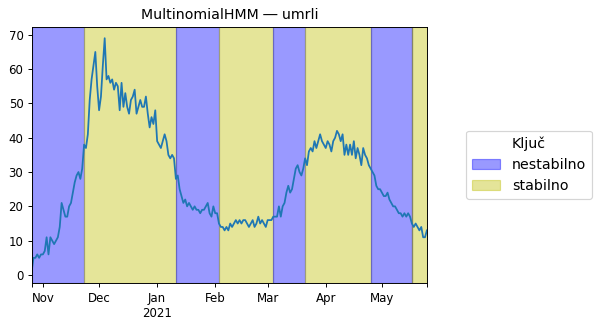

In [13]:
umrli = df['Umrli'].loc['2020-10-26':]

model = HMM(MultinomialHMM, n_components=2).fit(umrli)

model.plot(umrli, ['b', 'y'], ['nestabilno', 'stabilno'])

Štaviše, binarno tumačenje stabilnosti moglo bi se proširiti prostom proverom da li je do promene stanja došlo padom ili porastom broja – npr. promena u nestabilno padom označava silaznu putanju. Kako to izgleda, vidi se u nastavku – crven je rast, zelen pad, narandžast pik (ili visoki plato), a žut niski plato. Ovime je dobijeno nešto što liči na početnu zamisao, koja je **određivanje tačnih faza pandemije**. Primera radi, ovakav model mogao bi se iskoristiti tako da već krajem oktobra zna da treba pooštriti protivepidemijske mere, jer dolazi rastući deo talasa. S druge strane, krajem maja se čini da ih je u redu popustiti. Još jednom, oba odgovaraju stvarnosti, pošto je npr. radno vreme kafića stvarno skraćeno u novembru, kao uzlaznom periodu, a zatim produženo u decembru, kao relativo stabilnom periodu. U martu, još jednom uzlaznom periodu, kafići su u potpunosti bili zatvoreni. Sve se, međutim, desilo kasnije u odnosu na predviđanja (crne isprekidane linije), pa se uz model moglo ranije i verovatno efikasnije odreagovati, kako se i vidi u prikazu u nastavku.

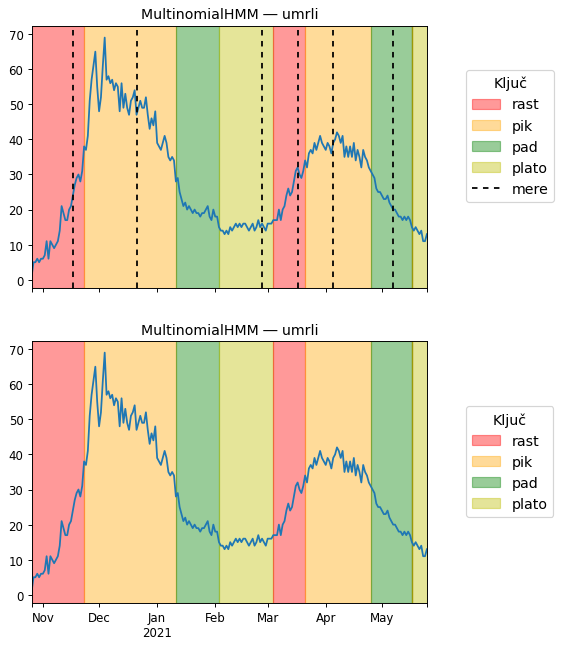

In [14]:
mere = ['2020-11-17', # pojačane zabrane rada
        '2020-12-21', # popuštene zabrane rada
        '2021-02-26', # skraćeno radno vreme
        '2021-03-17', # zatvoreni ugostitelji
        '2021-04-05', # otvoreni ugostitelji
        '2021-05-07'] # skoro sve otvoreno

ax1, ax2 = grafici(2)

model.plot_change(umrli, ax=ax2)
model.plot_change(umrli, mere, ax1)

## Veći broj stanja

Za veći broj skrivenih stanja, rezultati baš i **nisu smisleni**, pa se ne mogu previše detaljno razmotriti. Model sa tri stanja dosta liči na onaj sa dva, dok model sa četiri stanja izgleda kao da dobro pokriva prvi deo epidemije – zdravo i aktivno stanje – ali u drugom delu postoji dosta ne toliko smislenog mešanja.

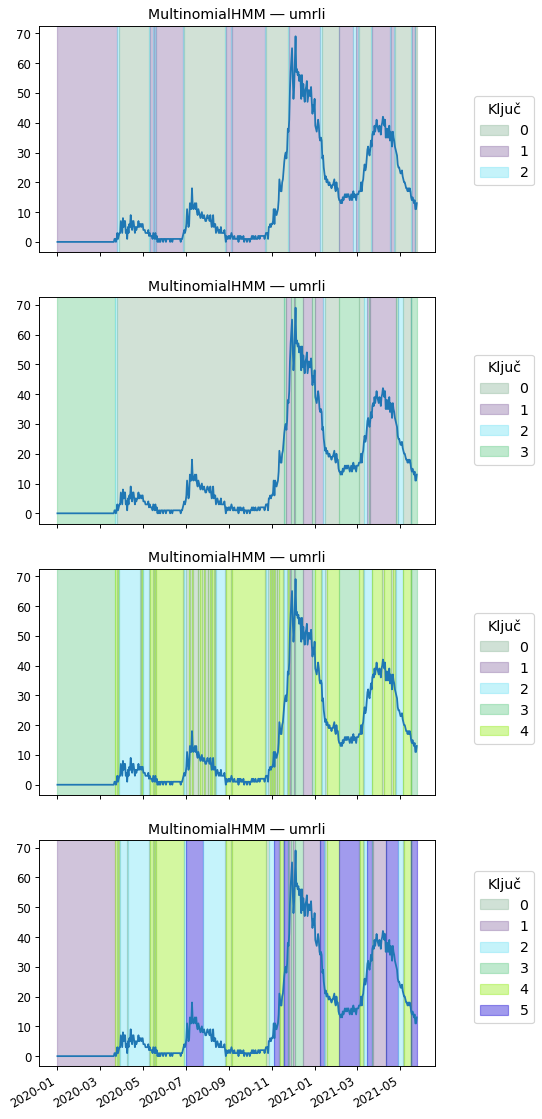

In [15]:
for i, ax in enumerate(grafici(4), 3):
    HMM(MultinomialHMM, n_components=i).fit(df['Umrli']).plot(df['Umrli'], ax=ax)

## Ostale serije

Rad sa podacima o novozaraženim i aktivnim slučajevima nije moguć, pošto su rezultujući modeli **degenerisani** – više je slobodnih parametara nego dana.

Fitting a model with 16001 free scalar parameters with only 510 data points will result in a degenerate solution.
Fitting a model with 246077 free scalar parameters with only 510 data points will result in a degenerate solution.


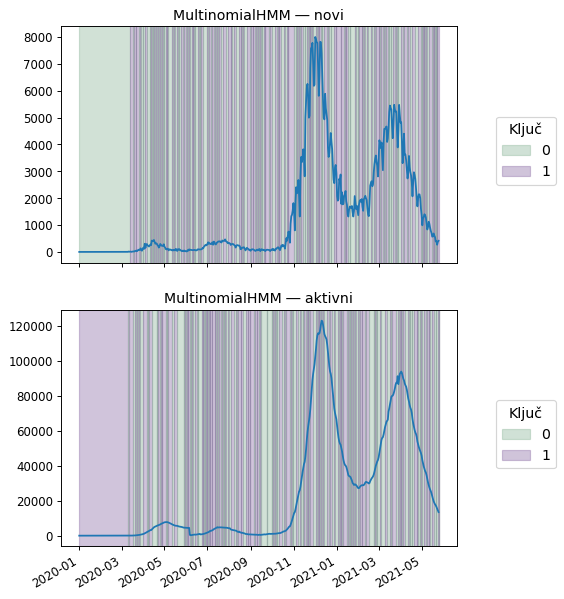

In [16]:
for i, ax in enumerate(grafici(2)):
    HMM(MultinomialHMM, n_components=2).fit(df.iloc[:, i]).plot(df.iloc[:, i], ax=ax)

## Razlike i pokretni prosek

Prvi pokušaj strogo je ograničen na broj umrlih, koji jedini imaju mali opseg vrednosti, pa nema posebne eksplozije stanja unutar HMM. Ipak, neophodna je **dodatna diskretizacija** podataka kako bi se multinomijalni HMM uspešno primenio na novozaražene i aktivne, čiji je opseg znatno veći.

In [17]:
for col in df.columns:
    print(f'Broj simbola {col.lower()}h bez pripreme:', df[col].max()+1)

Broj simbola novih bez pripreme: 8000
Broj simbola aktivnih bez pripreme: 123038
Broj simbola umrlih bez pripreme: 70


Prvi način da se to postigne moglo bi biti svođenje vremenske serije na niz **apsolutnih razlika prvog reda**, što značajno smanjuje opseg.

In [18]:
dff = df.copy()

for col in dff.columns:
    dff[col] = np.abs(np.ediff1d(dff[col], to_begin=0))
    print(f'Broj simbola {col.lower()}h sa razlikom prvog reda:', dff[col].max()+1)

Broj simbola novih sa razlikom prvog reda: 2182
Broj simbola aktivnih sa razlikom prvog reda: 6289
Broj simbola umrlih sa razlikom prvog reda: 13


In [19]:
dff

,Novi,Aktivni,Umrli
2020-01-01,0,0,0
2020-01-02,0,0,0
2020-01-03,0,0,0
2020-01-04,0,0,0
2020-01-05,0,0,0
...,...,...,...
2021-05-21,159,597,1
2021-05-22,13,846,1
2021-05-23,138,1035,3
2021-05-24,110,1026,0


Ovo smanjenje, međutim, **nije dovoljno** da model nad podacima o novozaraženim i aktivnim slučajevima ne bude degenerisan, a pritom daje vrlo loš rezultat nad podacima o umrlim potvrđenim pacijentima, za koje je već otkriveno rešenje fer kvaliteta, tako da se od njega odustaje.

Fitting a model with 4365 free scalar parameters with only 510 data points will result in a degenerate solution.
Fitting a model with 12579 free scalar parameters with only 510 data points will result in a degenerate solution.


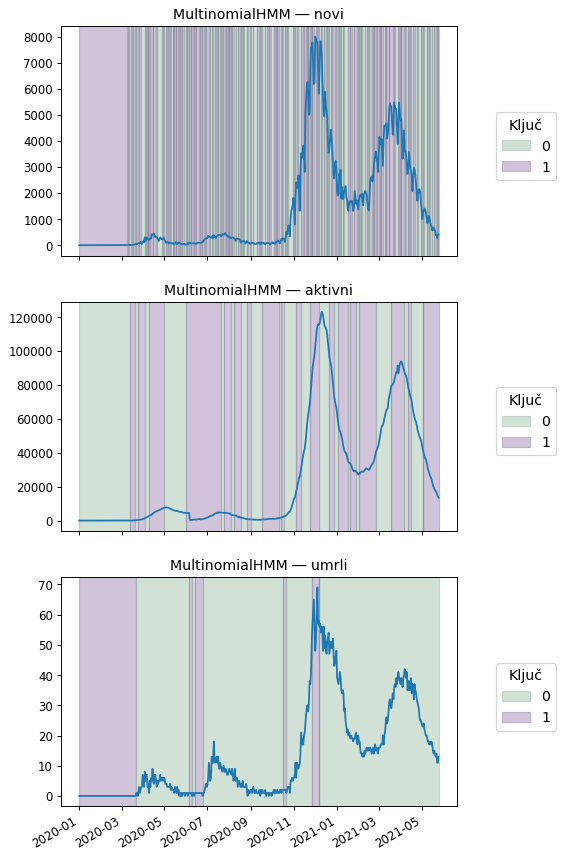

In [20]:
for i, ax in enumerate(grafici(3)):
    HMM(MultinomialHMM, n_components=2).fit(dff.iloc[:, i]).plot(df.iloc[:, i], ax=ax)

Sledeći pokušaj nadovezuje se na prethodni tako što sirove podatke menja **pokretnim prosekom** (*moving* ili *rolling average*) na nivou sedmice.

In [21]:
dff = df.rolling(7).mean().fillna(0).round().astype(int)

for col in dff.columns:
    dff[col] = np.abs(np.ediff1d(dff[col], to_begin=0))
    print(f'Broj simbola {col.lower()}h sa razlikom pokretnih proseka:', dff[col].max()+1)

Broj simbola novih sa razlikom pokretnih proseka: 396
Broj simbola aktivnih sa razlikom pokretnih proseka: 4287
Broj simbola umrlih sa razlikom pokretnih proseka: 6


In [22]:
dff

,Novi,Aktivni,Umrli
2020-01-01,0,0,0
2020-01-02,0,0,0
2020-01-03,0,0,0
2020-01-04,0,0,0
2020-01-05,0,0,0
...,...,...,...
2021-05-21,57,1166,1
2021-05-22,43,1104,0
2021-05-23,43,1027,1
2021-05-24,28,950,1


Problem sa degenerisanošću i dalje **nije rešen**, a rezultati nad već obrađenim podacima o umrlim pacijentima još jednom su lošiji nego pri prvom pokušaju.

Fitting a model with 793 free scalar parameters with only 510 data points will result in a degenerate solution.
Fitting a model with 8575 free scalar parameters with only 510 data points will result in a degenerate solution.


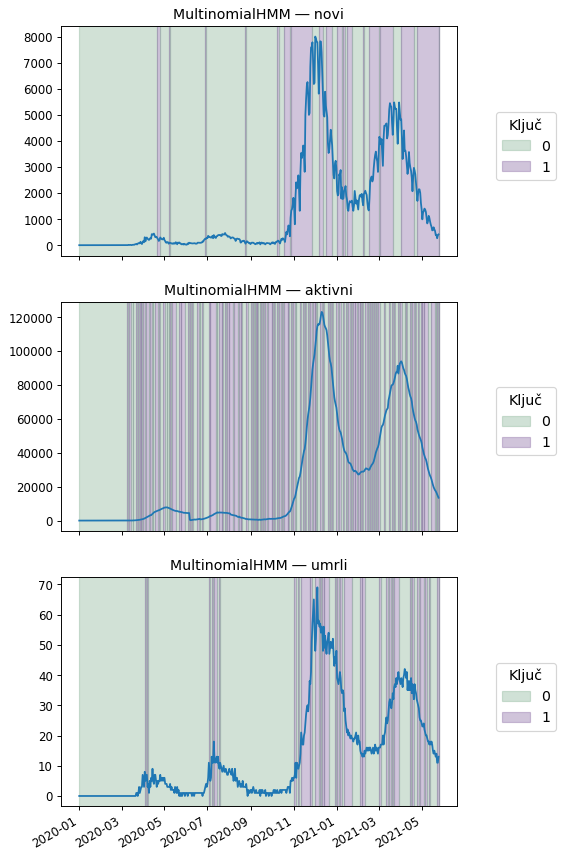

In [23]:
for i, ax in enumerate(grafici(3)):
    HMM(MultinomialHMM, n_components=2).fit(dff.iloc[:, i]).plot(df.iloc[:, i], ax=ax)

Na kraju je oprobana i verzija gde se na podatke o umrlima primenjuje **samo tehnika pokretnog proseka**, bez dodatnih razlika prvog reda.

In [24]:
umrli = df['Umrli'].rolling(7).mean().fillna(0).round().astype(int)

print(f'Broj simbola umrlih sa pokretnim prosekom:', umrli.max()+1)

Broj simbola umrlih sa pokretnim prosekom: 60


In [25]:
umrli

2020-01-01     0
2020-01-02     0
2020-01-03     0
2020-01-04     0
2020-01-05     0
              ..
2021-05-21    15
2021-05-22    15
2021-05-23    14
2021-05-24    13
2021-05-25    13
Name: Umrli, Length: 510, dtype: int32

Iako je kriva podataka (tamnija) **glatkija**, rezultati su ipak **manje korisni** od modela dobijenog bez uprosečavanja i ne čini se da se mogu protumačiti.

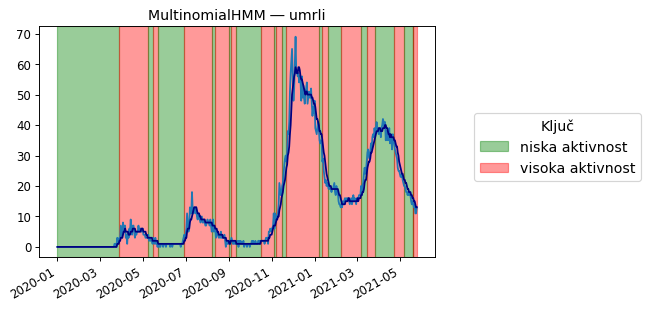

In [26]:
model = HMM(MultinomialHMM, n_components=2).fit(umrli)

model.plot(df['Umrli'], 2*['w'])
model.plot(umrli, ['g', 'r'], ['niska aktivnost', 'visoka aktivnost'], color='navy')

## Napredni diskretni HMM

Razlike i pokretni prosek nisu rešili problem degenerisanost modela. Stoga je neophodno **radikalnije pristupiti diskretizaciji**. Prvi pokušaj u tom smeru vrlo je jednostavan – umesto apsolutne razlike, čuva se samo njen **znak**. Ovime se svaki skup emisija svodi na samo dva simbola, što je ogromno uprošćenje.

In [27]:
dff = df.rolling(7).mean().fillna(0)

for col in dff.columns:
    dff[col] = np.int64(np.ediff1d(dff[col], to_begin=0) > 0)
    print(f'Broj simbola {col.lower()}h sa znakom razlike:', dff[col].max()+1)

Broj simbola novih sa znakom razlike: 2
Broj simbola aktivnih sa znakom razlike: 2
Broj simbola umrlih sa znakom razlike: 2


In [28]:
dff

,Novi,Aktivni,Umrli
2020-01-01,0,0,0
2020-01-02,0,0,0
2020-01-03,0,0,0
2020-01-04,0,0,0
2020-01-05,0,0,0
...,...,...,...
2021-05-21,0,0,0
2021-05-22,0,0,0
2021-05-23,0,0,0
2021-05-24,0,0,0


Ovakav model najbolje se ponaša na skupu **aktivnih**, pa su u nastavku idvojene njegove karakteristike, dok rezultati nad ostalim podacima nisu ni prikazani. I ovoga puta je skoro pa sigurno da se kreće iz silaznog (normalnog) toka, što i jeste slučaj u podacima. Nešto je veća verovatnoća da se ostane u istom stanju, nego da se ono promeni. Očekivano, takođe je veća verovatnoća da silazni tok emituje smanjenje broja slučajeva, a uzlazni povećanje.

In [29]:
model = HMM(MultinomialHMM, n_components=2).fit(dff['Aktivni'])

model.opis()

Broj simbola: 2
Broj skrivenih stanja: 2

Polazne verovatnoće:
[0.08043471 0.91956529]

Matrica prelaza:
[[0.57666079 0.42333921]
 [0.4206438  0.5793562 ]]

Matrica emisija:
[[0.39801032 0.60198968]
 [0.62437299 0.37562701]]


Uprkos dobrom ponašavanju, valjda napomenuti da model nije preterano pametan. Naime, uglavnom prati rezultujuću pravougaonu meandarsku funkciju (*square wave*). Ipak, nije ni u potpunosti naivan, pošto zahteva pripremu pokretnih proseka, a primećuje se i da je na dva mesta uspešno ignorisao nevažan jednodnevni rast i pad proseka. Sve u svemu, dobro predviđa **početak uzlazne putanje** broja aktivnih, dok nije preterano optimističan po pitanju **prelaska u silaznu putanju**. Obe osobine su dobre, jer adekvatno predviđena uzlazna putanja može pomoći u planiranju **mera** i **proširenja bolničkih kapaciteta**, dok odloženo predviđanje silazne putanje sprečava prerano **popuštanje** mera i **smanjenje** zdravstvenih kapaciteta namenjenih kovid pacijentima.

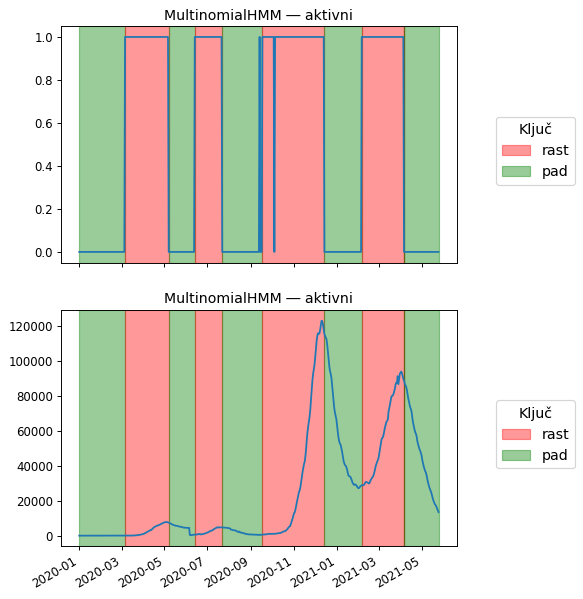

In [30]:
ax1, ax2 = grafici(2)

model.plot(dff['Aktivni'], ['r', 'g'], ['rast', 'pad'], ax1)
model.plot(df['Aktivni'], ['r', 'g'], ['rast', 'pad'], ax2)

Kako je model suštinski jednostavan, sa malim brojem simbola i skrivenih stanja, moguće je i **ručno mu podesiti parametre**, tako da bude sigurniji u ono što je naučio. U primeru koji sledi, podešen je tako da strogo polazi iz normalnog stanja, a tek u petini slučajeva menja stanje i emituje neodgovarajući simbol.

In [31]:
model.start([0, 1])
model.trans([[0.8, 0.2],
             [0.2, 0.8]])
model.emiss([[0.2, 0.8],
             [0.8, 0.2]])

model.opis()

Broj simbola: 2
Broj skrivenih stanja: 2

Polazne verovatnoće:
[0 1]

Matrica prelaza:
[[0.8 0.2]
 [0.2 0.8]]

Matrica emisija:
[[0.2 0.8]
 [0.8 0.2]]


Rezultati, međutim, nisu ništa bolji – u potpunosti su nepromenjeni (samo za aktivne su dobri), mada je značajan zaključak da se **učenje može preskočiti**.

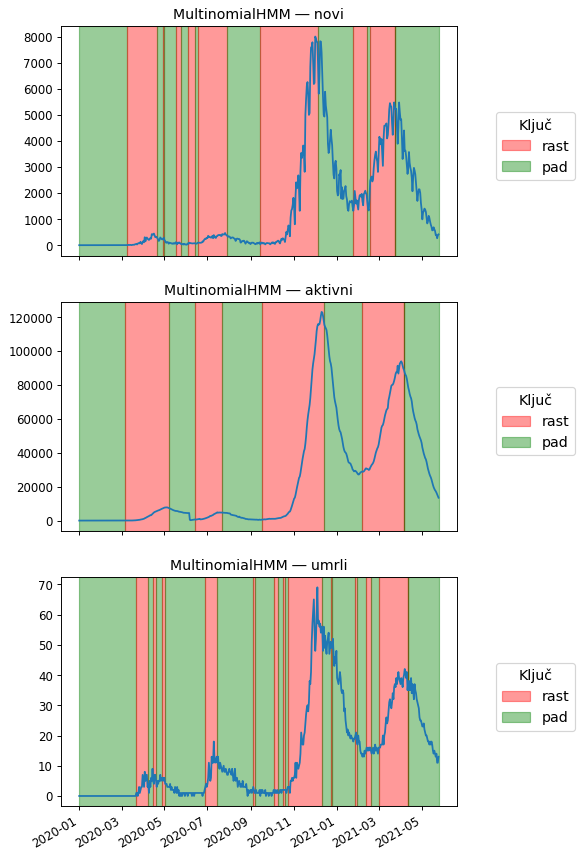

In [32]:
axs = grafici(3)

for i, ax in enumerate(axs):
    model.refit(dff.iloc[:, i]).plot(df.iloc[:, i], ['r', 'g'], ['rast', 'pad'], ax)

Stabilniji rezultat, ujednačen za sve tri serije, moguće je dobiti **višestrukim uprosečavanjem**, mada je kod njega, očekivano, pad odloženo predviđen, jer proseci nešto kasnije opadaju. Stoga je verovatno smislenije predviđena stanja tumačiti kao visoku i nisku aktivnost umesto kao rast i pad.

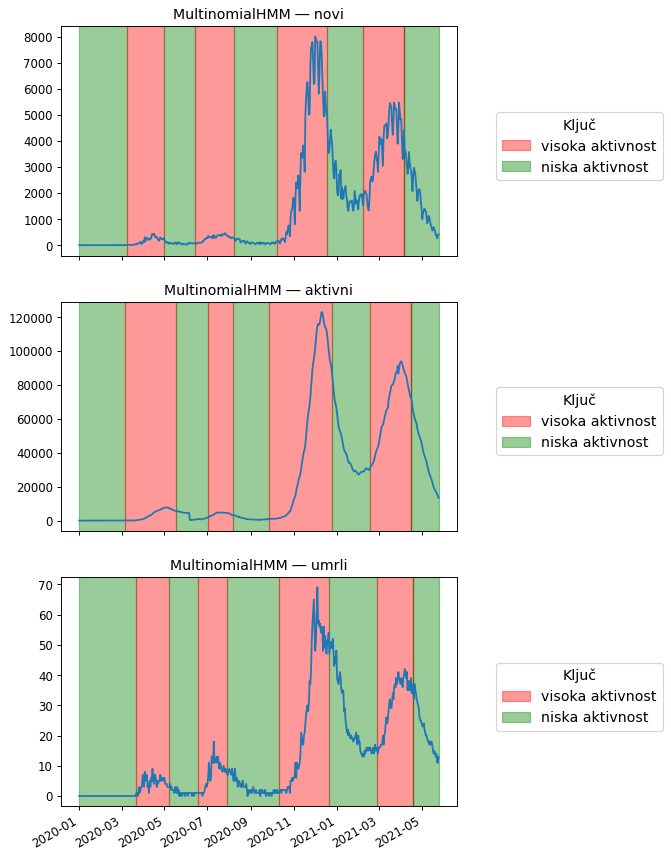

In [33]:
dff = df.rolling(7).mean().fillna(0) \
        .rolling(10).mean().fillna(0) \
        .rolling(14).mean().fillna(0)

for col in dff.columns:
    dff[col] = np.int64(np.ediff1d(dff[col], to_begin=0) > 0)

axs = grafici(3)

for i, ax in enumerate(axs):
    model.refit(dff.iloc[:, i]) \
         .plot(df.iloc[:, i], ['r', 'g'],
               ['visoka aktivnost', 'niska aktivnost'], ax)

## Nivelisanje promene

Kao krajnji pokušaj diskretizacije, umesto znaka razlike, moguće je probati sa procenom **stacionarnosti**. Vremenska serija, odnosno njen deo, stacionarna je kada nema velike promene u raspodeli s vremenom. Drugim rečima, vrednosti takve serije ne zavise od vremena, što odgovara platou i donekle piku epidemije. S druge strane, nestacionarna serija pokazuje jasan trend pada ili rasta. Dobra mera stacionarnosti jeste **pokretno standardno odstupanje**, koje je manje u stabilnijim delovima. Ipak, ono je osetljivo na apsolutne vrednosti, pa je još jednom neophodno epidemiju podeliti na dva dela.

In [34]:
dff = df.rolling(7).mean().fillna(0) \
        .rolling(7).std().fillna(0)
dff = skaliraj(dff)

dff1 = dff.loc[:'2020-10-31']
dff2 = dff.loc['2020-11-01':]

dff

,Novi,Aktivni,Umrli
2020-01-01,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000
2020-01-03,0.000000,0.000000,0.000000
2020-01-04,0.000000,0.000000,0.000000
2020-01-05,0.000000,0.000000,0.000000
...,...,...,...
2021-05-21,0.166341,0.300528,0.121160
2021-05-22,0.168132,0.289254,0.131847
2021-05-23,0.161542,0.277090,0.147471
2021-05-24,0.145770,0.263408,0.158238


Skalirani podaci mogu se uporediti sa pokretnim odstupanjima, gde se primećuje već pomenuta **veza između stacionarnosti i odstupanja**.

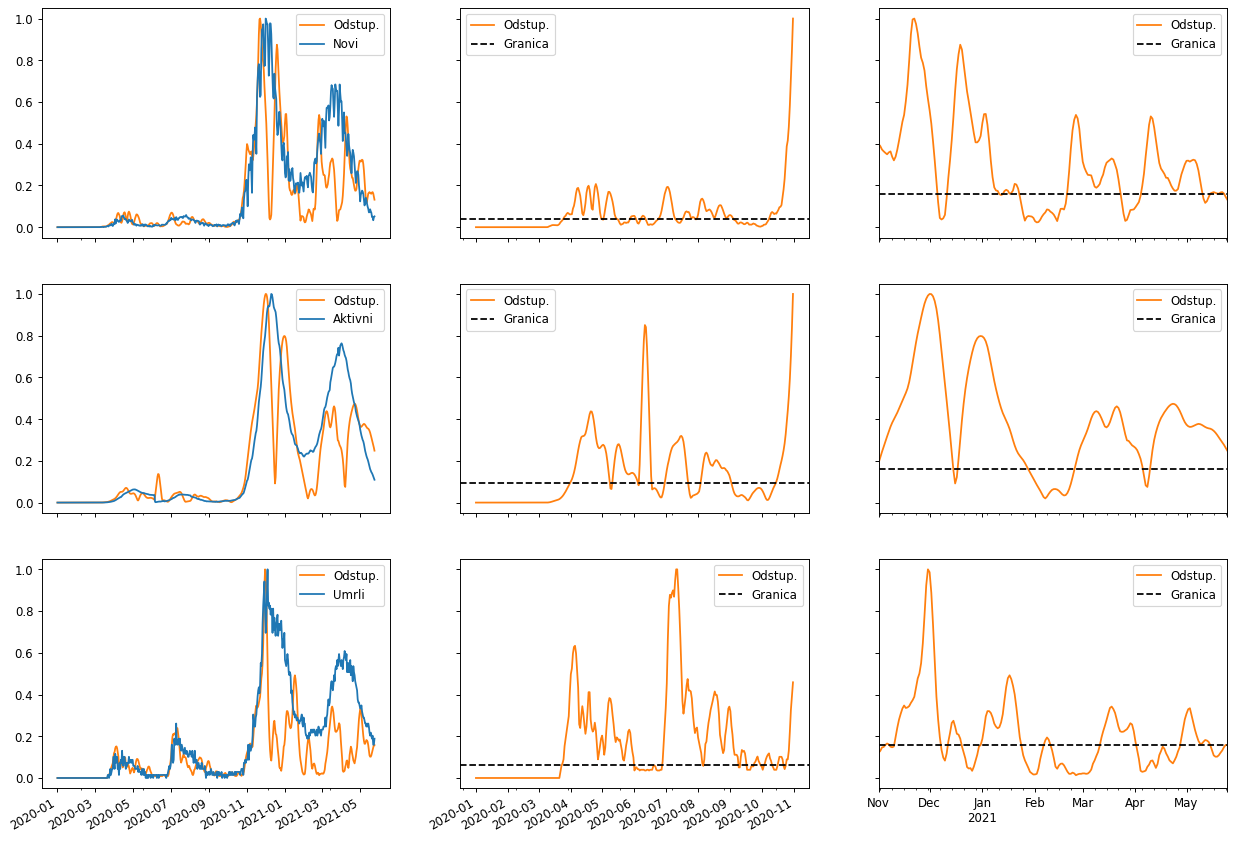

In [35]:
thresh1, thresh2 = 0.015, 0.16

for i, ax in enumerate(grafici(3, 3).flatten()):
    if not i % 3:
        std = dff.iloc[:, i//3]
    elif i % 3 == 1:
        std = dff1.iloc[:, i//3]
        thresh11 = thresh1 / std.max()
        std = std / std.max()
    else:
        std = dff2.iloc[:, i//3]
    
    std.plot(label='Odstup.', color='tab:orange', ax=ax)
    
    if not i % 3:
        skal.iloc[:, i//3].plot(ax=ax)
    elif i % 3 == 1:
        ax.axhline(thresh11, linestyle='--', color='black', label='Granica')
    else:
        ax.axhline(thresh2, linestyle='--', color='black', label='Granica')
    
    ax.legend()

Pokretna odstupanja menjaju se pretpostavljenim **indikatorom stacionarnosti**, nakon čega se odvojeni delovi ponovo spajaju u jedan skup.

In [36]:
dff = pd.concat(((dff1 < thresh1).astype(int),
                 (dff2 < thresh2).astype(int)))

dff

,Novi,Aktivni,Umrli
2020-01-01,1,1,1
2020-01-02,1,1,1
2020-01-03,1,1,1
2020-01-04,1,1,1
2020-01-05,1,1,1
...,...,...,...
2021-05-21,0,0,1
2021-05-22,0,0,1
2021-05-23,0,0,1
2021-05-24,1,0,1


Najbolja podela vremenske serije događa se kod **aktivnih slučajeva**. Slično naivnom diskrenom HMM, i ovde plavičasta boja označava nestabilan tok epidemije, odnosno konstantan pad ili rast u proseku. Žuti delovi su pretpostavljeni stacionarni delovi serije, pa je tako ona podeljena prema stabilnosti. Zbog kombinovane primene pokretnih proseka i odstupanja, procene stabilnih stanja su malo **odložene**, ali to nije problematično, jer su nestabilna stanja važnija.

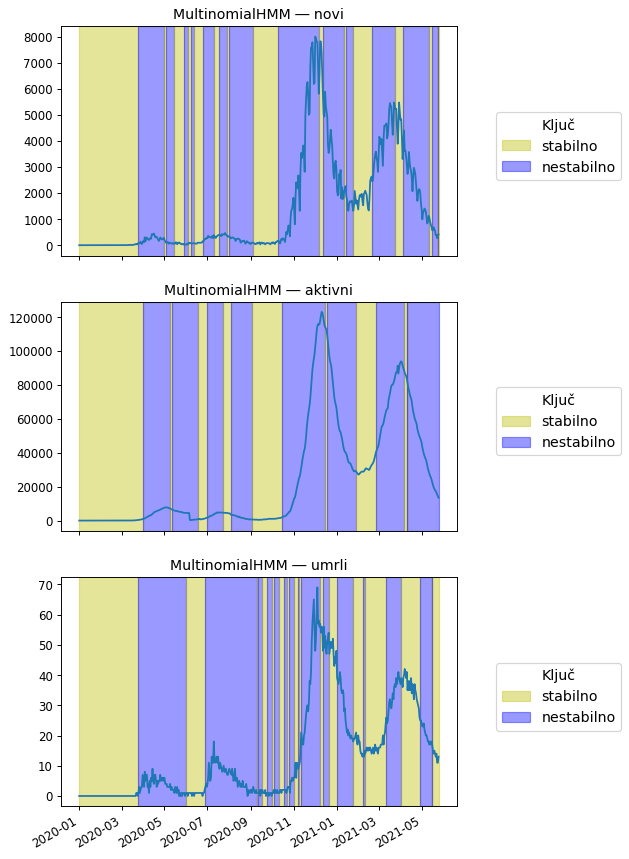

In [37]:
for i, ax in enumerate(grafici(3)):
    HMM(MultinomialHMM, n_components=2).fit(dff.iloc[:, i]) \
    .plot(df.iloc[:, i], ['y', 'b'], ['stabilno', 'nestabilno'], ax)

U nastavku su prikazane **karakteristike dobijenog modela**. Polazi se iz stabilnog stanja, a češće se ostaje u stanju nego što se ono menja. Zanimljivo je da za oba stanja verovatnije da emituju simbol nestacionarnosti, s tim što to daleko češće čini nestabilno stanje, dok su stabilnom verovatnoće oko polovine.

In [38]:
model = HMM(MultinomialHMM, n_components=2).fit(dff['Aktivni'])

model.opis()

Broj simbola: 2
Broj skrivenih stanja: 2

Polazne verovatnoće:
[0.95016047 0.04983953]

Matrica prelaza:
[[0.5565226  0.4434774 ]
 [0.41887643 0.58112357]]

Matrica emisija:
[[0.51238632 0.48761368]
 [0.71367831 0.28632169]]


Slično kao kod naivnog diskretnog HMM, i ovi rezultati mogu se srediti i tumačiti u kontekstu **protivepidemijskih mera**, što je i učinjeno u nastavku.

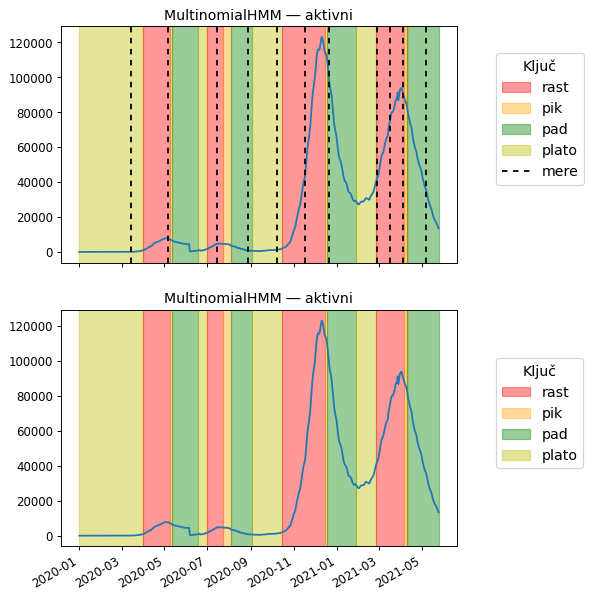

In [39]:
mere = ['2020-03-15', # proglašeno vanredno stanje
        '2020-05-06', # ukinuto vanredno stanje
        '2020-07-15', # pojačane mere: maske itd.
        '2020-08-28', # radno vreme posle ponoći
        '2020-10-07', # skraćeno radno vreme
        '2020-11-17', # pojačane zabrane rada
        '2020-12-21', # popuštene zabrane rada
        '2021-02-26', # skraćeno radno vreme
        '2021-03-17', # zatvoreni ugostitelji
        '2021-04-05', # otvoreni ugostitelji
        '2021-05-07'] # skoro sve otvoreno

ax1, ax2 = grafici(2)

model.plot_change(df['Aktivni'], ax=ax2)
model.plot_change(df['Aktivni'], mere, ax1)

## Neprekidni (Gausov) HMM

Kako je već napomenuto, upotreba diskretnih HMM nije najprirodnija na epidemiološkim podacima, pošto su ti brojevi, iako celi, suštinski neprekidni po prirodi. Iz tog razloga je u nastavku primenjen **neprekidni HMM**. Konkretno, primenjen je **Gausov HMM**, jedini tog tipa implementirani u okviru razmatrane biblioteke *hmmlearn*, koji umesto diskretne raspodele emisija pretpostavlja **normalnu raspodelu** i nastoji da otkrije njene parametre – **očekivanja** i **kovarijanse**.

In [40]:
from hmmlearn.hmm import GaussianHMM

Za početak, zgodno je **sakupiti sve dosad korišćene neprekidne podatke** na jedno mesto – sirove skupove, pokretne proseke, pokretna odstupanja.

In [41]:
dfm = df.rolling(7).mean().fillna(0)
dfs = dfm.rolling(7).std().fillna(0)

dff = pd.concat((df, dfm, dfs), axis=1)

dff

,Novi,Aktivni,Umrli,Novi,Aktivni,Umrli,Novi,Aktivni,Umrli
2020-01-01,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2021-05-21,391,17336,13,583.428571,20246.714286,15.142857,118.285916,2770.687401,0.985315
2021-05-22,404,16490,14,540.428571,19142.714286,14.571429,119.558924,2666.742207,1.072222
2021-05-23,266,15455,11,497.285714,18116.000000,13.714286,114.873116,2554.602593,1.199287
2021-05-24,376,14429,11,468.857143,17165.714286,13.142857,103.657656,2428.463267,1.286848


Kao i dosad, model je moguće ukalupiti u jednu seriju podataka. To je i učinjeno sa sirovim podacima, pri čemu se čini da su ovakvi modeli u stanju da razluče **visoku aktivnost od relativno niske** ukoliko se koristi ista matrica kovarijansi za svako stanje, odnosno **prvi deo epidemije od drugog** ukoliko se koristi po jedna puna matrica za svako pojedinačno stanje. Takođe, ovo najavljuje da naprekidni HMM daje relativno smislene rezultate nad podacima iz **svih serija**.

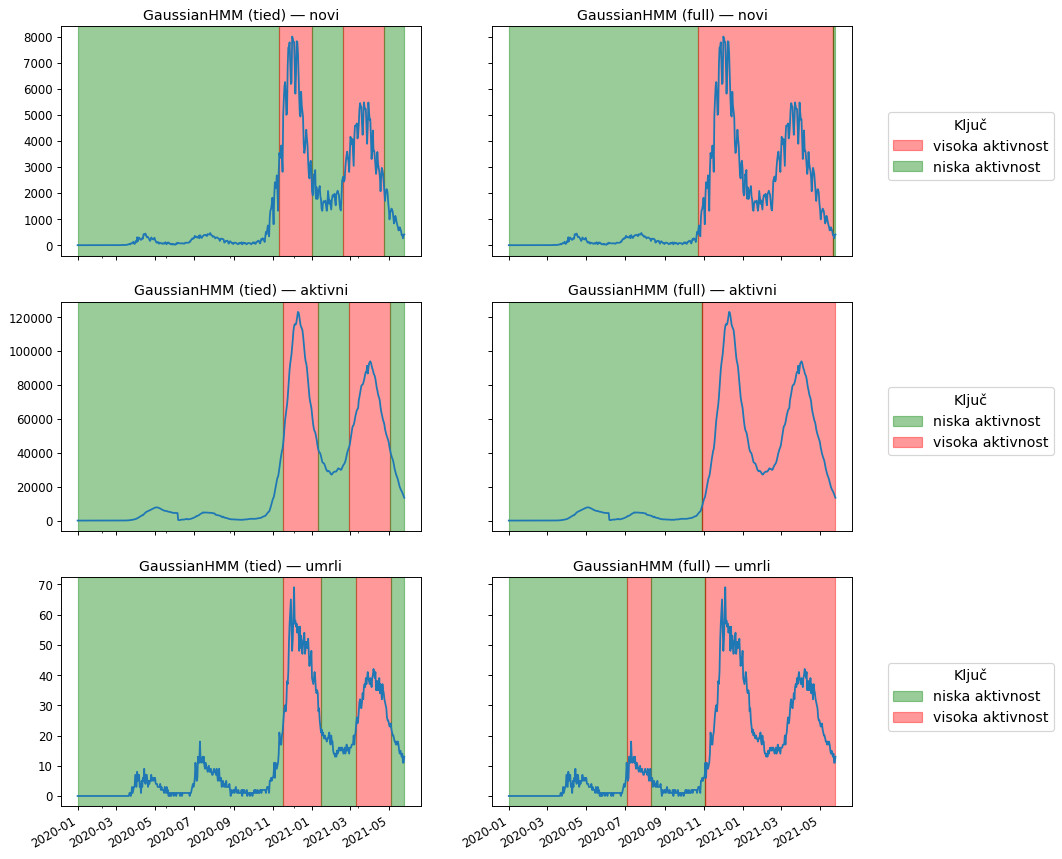

In [42]:
for i, ax in enumerate(grafici(3, 2).flatten()):
    covar = 'full' if i%2 else 'tied'
    podaci = dff.iloc[:, i//2]
    
    boje = ['r', 'g'] if i < 2 else ['g', 'r']
    oznake = ['visoka aktivnost', 'niska aktivnost'] if i < 2 \
             else ['niska aktivnost', 'visoka aktivnost']
    oznake = oznake if i%2 else []
    
    HMM(GaussianHMM, n_components=2, covariance_type=covar) \
       .fit(podaci).plot(podaci, boje, oznake, ax)

Ako se uzme više stanja, dobija se nivelisanija podela prema aktivnosti epidemije – izdvaja se **srednja aktivnost**, iz jednog ili dva nivoa.

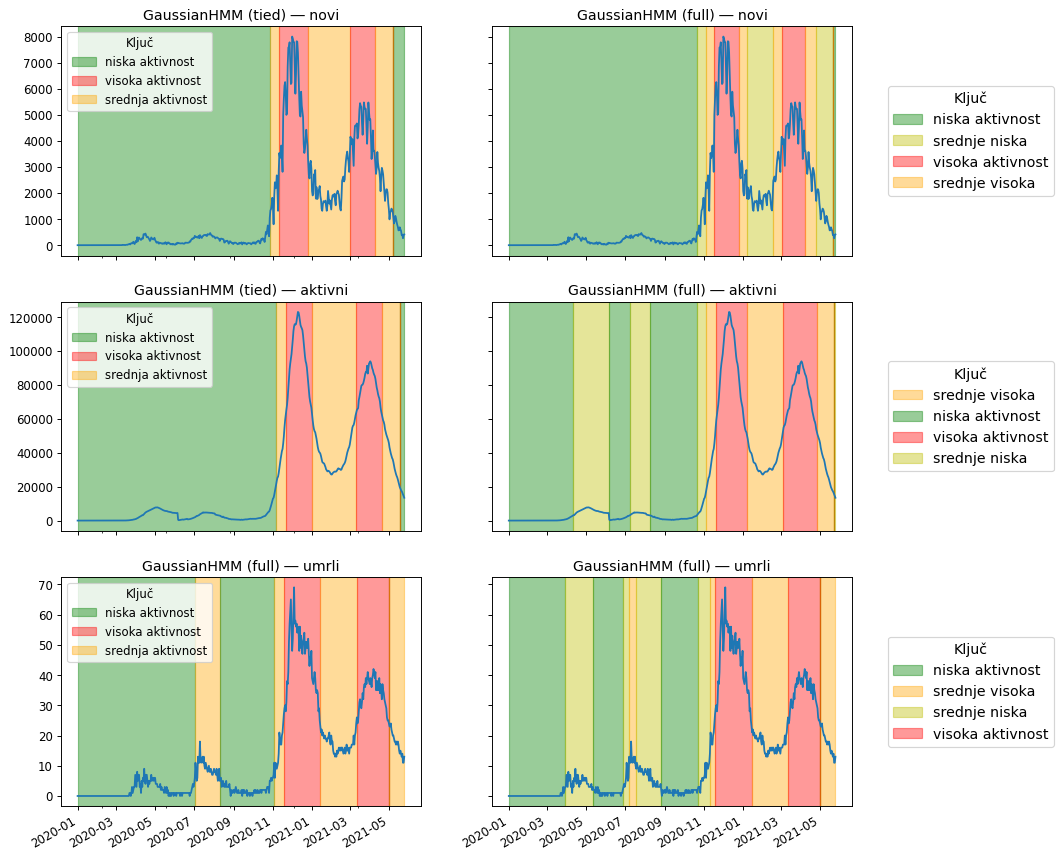

In [43]:
for i, ax in enumerate(grafici(3, 2).flatten()):
    covar = 'tied' if i in [0, 2] else 'full'
    podaci = dff.iloc[:, i//2]
    
    bojozn = {
        'g': 'niska aktivnost',
        'y': 'srednje niska',
        'orange': 'srednje visoka',
        'r': 'visoka aktivnost'
    }
    
    if not i%2:
        boje = ['g', 'r', 'orange']
        oznake = ['niska aktivnost', 'visoka aktivnost', 'srednja aktivnost']
    elif i == 1:
        boje = ['g', 'y', 'r', 'orange']
    elif i == 3:
        boje = ['orange', 'g', 'r', 'y']
    else:
        boje = ['g', 'orange', 'y', 'r']
    
    if i%2:
        oznake = [bojozn[b] for b in boje]
    
    HMM(GaussianHMM, n_components=3+i%2, covariance_type=covar) \
       .fit(podaci).plot(podaci, boje, oznake, ax, i%2)

Kako podaci o novozaraženima jedini dosad nisu detaljnije tumačeni, izdvaja se i opisuje model sa tri stanja nad njima. Broj simbola označava da je korišćena samo jedna serija pri *treniranju*. Očekivano, verovatnoća polaska iz stanja niske aktivnosti bliska je jedinici, a stanja se retko menjaju. Kada su u pitanju **srednje vrednosti**, najniže je očekivanje stanja niske aktivnosti, a najviše visoke, takođe očekivano. Kovarijanse su iste (*tied*), kako je i zahtevano.

In [44]:
HMM(GaussianHMM, n_components=3, covariance_type='tied').fit(dff['Umrli'].iloc[:, 0]).opis()

Broj simbola: 1
Broj skrivenih stanja: 3

Polazne verovatnoće:
[9.99998886e-01 1.63765764e-78 1.11441745e-06]

Matrica prelaza:
[[9.92094141e-01 4.99298771e-14 7.90585871e-03]
 [1.01453956e-13 9.79409160e-01 2.05908401e-02]
 [1.07699433e-02 1.64103254e-02 9.72819731e-01]]

Srednje vrednosti:
[[ 2.25380088]
 [41.89565128]
 [16.87302091]]

Kovarijanse:
[[[26.25020806]]

 [[26.25020806]]

 [[26.25020806]]]


## Multivarijantni modeli

Posebna prednost neprekidnih HMM jeste to što se mogu **ukalupiti u više serija istovremeno**, odnosno ulaz može imati više karakteristika umesto samo jednu. Tako je u nastavku napravljen skriveni Markovljev model nad svim sračunatim podacima. Kako su za svako stanje korišćene pune matrice kovarijansi, model zbog glomaznosti nije opisan štampanjem. Model ima tri stanja i devet simbola, pa je rezultujuća matrica dimenzija 3 × 9 × 9, što su 243 vrednosti.

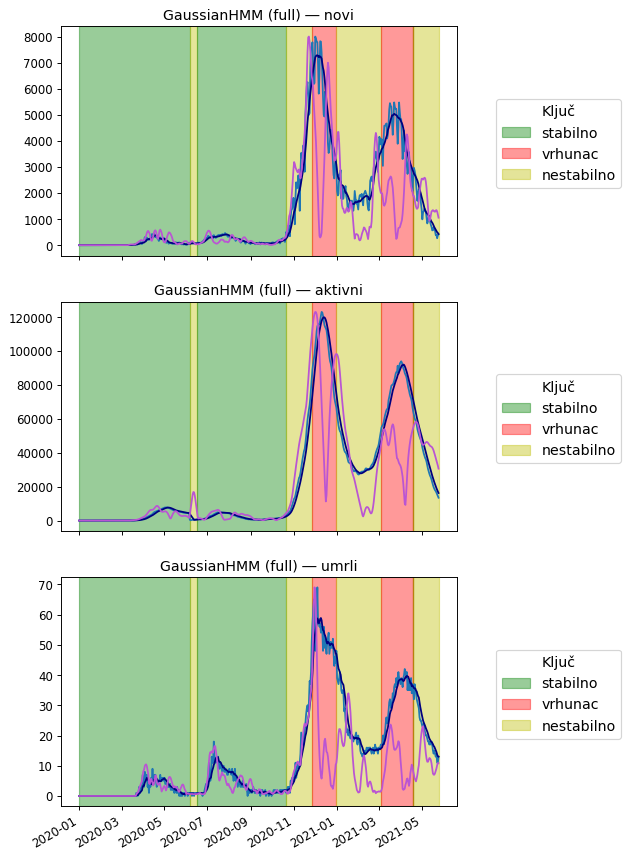

In [45]:
model = HMM(GaussianHMM, n_components=3,
            covariance_type='full').fit(dff)

for i, ax in enumerate(grafici(3, 1)):
    sirovi = dff.iloc[:, i]
    model.plot(sirovi, 3*['w'], ax=ax)
    
    proseci = dff.iloc[:, i+3]
    model.plot(proseci, 3*['w'], ax=ax, color='navy')
    
    odstupanja = dff.iloc[:, i+6]
    odstupanja = odstupanja / odstupanja.max()
    odstupanja = odstupanja * sirovi.max()
    model.plot(odstupanja, ['g', 'r', 'y'],
               ['stabilno', 'vrhunac', 'nestabilno'],
               ax, color='mediumorchid')

Poslednji pokušaj rada sa naprekidnim HMM mogao bi biti uključivanje podataka iz **susednih država** kao novi simbol. Na taj način bi se mogao ispitati uticaj stanja u susedstvu i sasvim moguće dobiti bolji model. Izdvojeni su podaci iz **Hrvatske** i **Bosne i Hercegovine** kao potencijalno najrelevantniji.

In [46]:
drzave = ['croatia', 'bosnia-and-herzegovina']
brojevi = ['graph-cases-daily', 'graph-active-cases-total', 'graph-deaths-daily']

dff = df

for drzava in drzave:
    for broj in brojevi:
        dff = pd.concat((dff, data(drzava, broj)), axis=1)

dff = dff.loc[:'2021-05-25'].fillna(0).astype(int)

dff.columns = [f'{d}{col}' for d in ('s', 'c', 'b') for col in df.columns]

dff

,sNovi,sAktivni,sUmrli,cNovi,cAktivni,cUmrli,bNovi,bAktivni,bUmrli
2020-01-01,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2021-05-21,391,17336,13,525,4633,28,132,22037,12
2021-05-22,404,16490,14,518,4361,27,103,22131,9
2021-05-23,266,15455,11,251,3881,20,83,22200,14
2021-05-24,376,14429,11,74,3263,26,55,21511,19


Podaci su **sačuvani lokalno**, kako bi sveska bila upotrebljiva i u slučaju da modul za učitavanje ili sajt koji služi kao izvor podataka u nekom trenutku padnu.

In [47]:
dff.to_csv('COVID-19 podaci.csv')

Primećuje se da postoje **velika preklapanja** u toku epidemije u ove tri države, što je dobar znak da ih ima svrhe kombinovati i porediti.

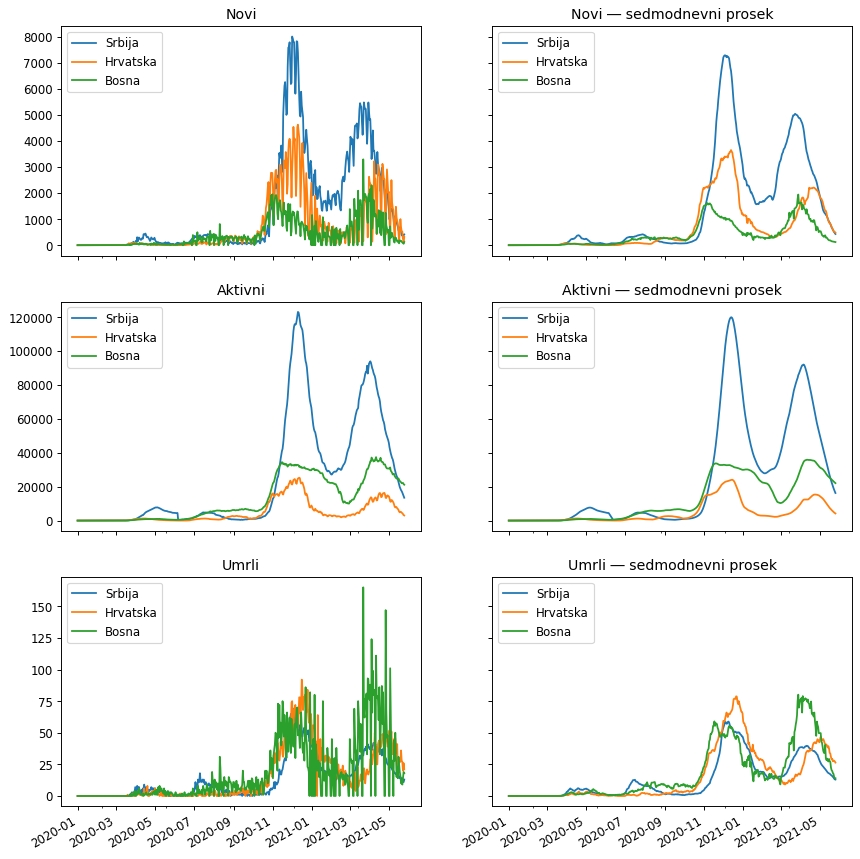

In [48]:
for i, ax in enumerate(grafici(3, 2).flatten()):
    srbija = dff.iloc[:, i//2]
    hrvatska = dff.iloc[:, i//2+3]
    bosna = dff.iloc[:, i//2+6]
    
    if i%2:
        srbija = srbija.rolling(7).mean().fillna(0)
        hrvatska = hrvatska.rolling(7).mean().fillna(0)
        bosna = bosna.rolling(7).mean().fillna(0)
    
    dod = ' ― sedmodnevni prosek' if i%2 else ''
    col = f'{df.columns[i//2]}{dod}'
    
    srbija.plot(ax=ax, title=col, label='Srbija')
    hrvatska.plot(ax=ax, title=col, label='Hrvatska')
    bosna.plot(ax=ax, title=col, label='Bosna')
    
    ax.legend(loc='upper left')

Rezultati dobijeni primenom modela sa manjim brojem stanja vrlo su slični onim bez podataka o susednim državama, mada su nešto **skeptičniji**. Naime, krajem maja, verovatno zbog manjeg obima vakcinacije, u regionu je bilo lošije stanje nego u Srbiji. Stoga je procenjena srednja aktivnost umesto niske.

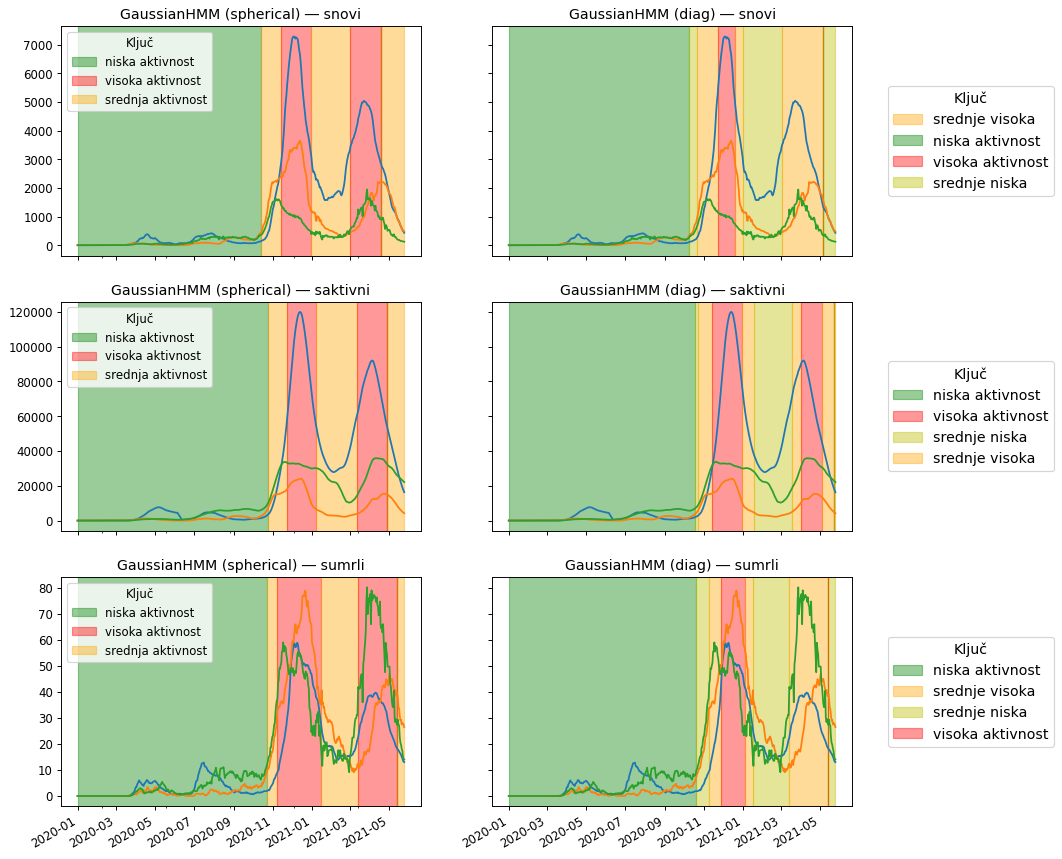

In [49]:
for i, ax in enumerate(grafici(3, 2).flatten()):
    covar = 'diag' if i%2 else 'spherical'
    
    podaci = dff.iloc[:, [i//2 + 3*j for j in range(3)]]
    podaci = podaci.rolling(7).mean().fillna(0)
    
    podaci.name = dff.columns[i//2]
    
    bojozn = {
        'g': 'niska aktivnost',
        'y': 'srednje niska',
        'orange': 'srednje visoka',
        'r': 'visoka aktivnost'
    }
    
    if not i%2:
        boje = ['g', 'r', 'orange']
        oznake = ['niska aktivnost', 'visoka aktivnost', 'srednja aktivnost']
    elif i == 1:
        boje = ['orange', 'g', 'r', 'y']
    elif i == 3:
        boje = ['g', 'r', 'y', 'orange']
    else:
        boje = ['g', 'orange', 'y', 'r']
    
    if i%2:
        oznake = [bojozn[b] for b in boje]
    
    HMM(GaussianHMM, n_components=3+i%2, covariance_type=covar) \
       .fit(podaci).plot(podaci, boje, oznake, ax, i%2)

## Veći broj stanja

Za kraj, izdvojena su dva modela koja koriste veći broj skrivenih stanja – njih **čak devet** – kao i punu matricu kovarijansi.

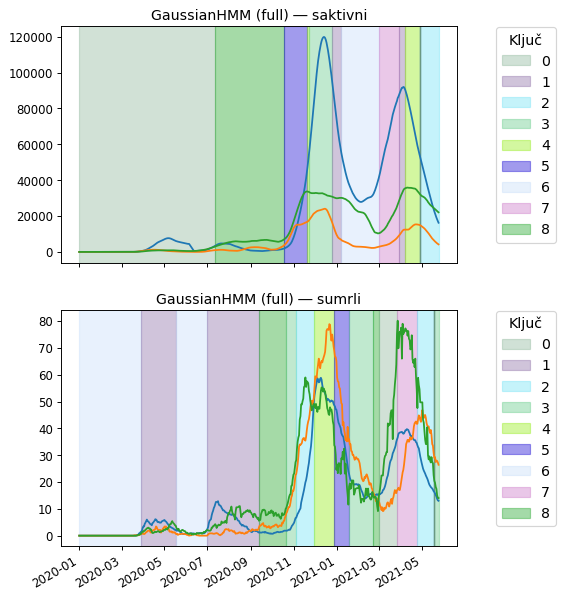

In [50]:
pods, mods = [], []

for i, ax in enumerate(grafici(2)):
    podaci = dff.iloc[:, [i + 1 + 3*j for j in range(3)]]
    podaci = podaci.rolling(7).mean().fillna(0)
    
    podaci.name = dff.columns[i+1]
    pods.append(podaci)
    
    model = HMM(GaussianHMM, n_components=9, covariance_type='full')
    mods.append(model)
    
    model.fit(podaci).plot(podaci, ax=ax)

Izdvojena stanja mogu se spojiti tako da se na podacima o aktivnim slučajevima tačno izdvoje **faze epidemije**, kao u nastavku.

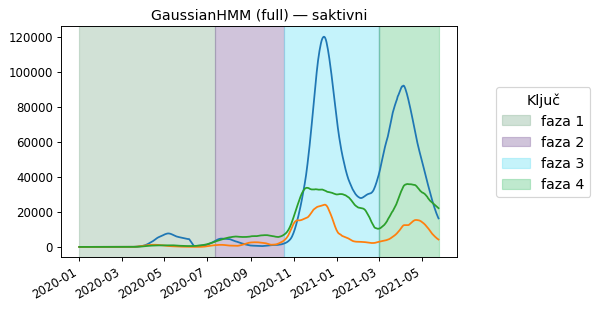

In [51]:
mods[0].plot_parts(pods[0], 1, 1, 5, 4)

Izdvojena stanja mogu se spojiti tako da se na podacima o umrlim pacijentima tačno izdvoje **talasi epidemije**, kao u nastavku.

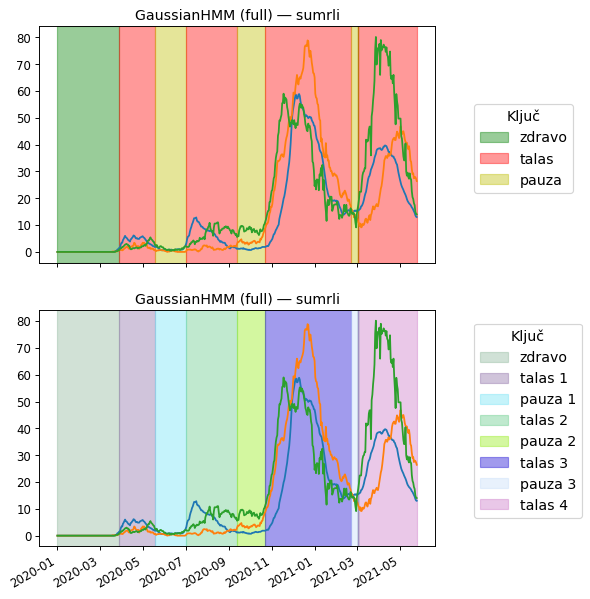

In [52]:
 mods[1].plot_waves(pods[1], 1, 1, 5, 4)

## Uklapanje u raspodelu

Kako je primećeno iz prethodnog razmatranja, epidemija se može podeliti u **četiri faze**, odnosno **četiri talasa**, između kojih postoje **pauze** i **preklapanja**. Kako to tačno izgleda, dato je na primeru podataka o aktivnim slučajevima, pošto je u pitanju vrlo glatka serija i najviše se čini da je iz pravilne raspodele.

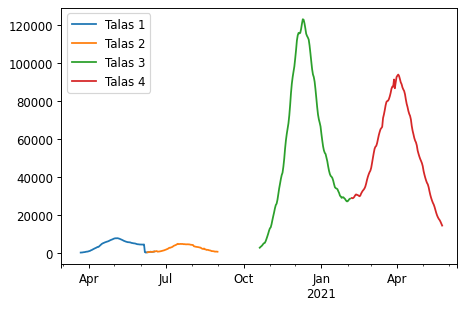

In [53]:
talasi = [np.arange(np.datetime64('2020-03-22'),
                    np.datetime64('2020-06-18')),
          np.arange(np.datetime64('2020-06-09'),
                    np.datetime64('2020-09-01')),
          np.arange(np.datetime64('2020-10-20'),
                    np.datetime64('2021-02-05')),
          np.arange(np.datetime64('2021-02-06'),
                    np.datetime64('2021-05-25'))]

for i, talas in enumerate(talasi, 1):
    df['Aktivni'][talas].plot(legend=True, label=f'Talas {i}')

_ = plt.xlim(left=np.datetime64('2020-02-28'),
             right=np.datetime64('2021-06-10'))

Pretpostavka je da svi razmatrani podaci potiču iz normalnih raspodela. Stoga je moguće njihovo **uklapanje u pretpostavljenu raspodelu** (*curve fitting*). Mada su drugi i treći talas donekle udaljeni, sa izraženom pauzom, čini se da se prvi i drugi, a pogotovu treći i četvrti, dobrim delom preklapaju.

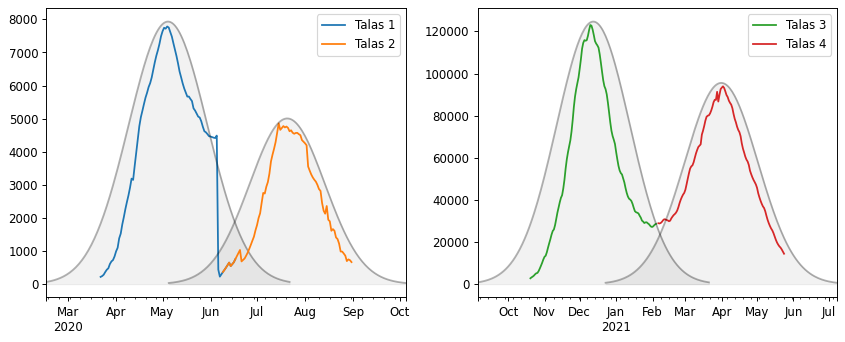

In [54]:
from scipy.stats import norm
from datetime import timedelta

k = 0
boje = plt.get_cmap('tab10')

for i, ax in enumerate(grafici(1, 2, False, False)):
    for j, talas in enumerate(talasi, 1):
        if j not in range(2*i+1, 2*i+3): continue
        
        dft = df['Aktivni'][talas]
        dft.plot(legend=True, label=f'Talas {j}', color=boje(k), ax=ax)
        
        k += 1
        
        vals = dft.index.values
        dodatak = int(timedelta(days=1).total_seconds()) * 10**9
        
        vals = [*[vals[0] - i*dodatak for i in range(35+10*i, 0, -1)], *vals]
        vals = [*vals, *[vals[-1] + i*dodatak for i in range(1, 36+10*i)]]
        
        raspvals = range(len(vals))
        raspind = range(len(dft.index))

        mu = np.mean(raspvals)
        sd = np.std(raspind)
        
        maxx = (dft.max() + 150 * (10*i+1))
        skala = sd * np.sqrt(2 * np.pi)
        skala = maxx * skala

        raspodela = norm.pdf(raspvals, mu, sd)
        raspodela = skala * raspodela

        ax.plot(vals, raspodela, color='black', alpha=.3)
        ax.fill_between(vals, raspodela, color='black', alpha=.05)
        ax.set_xlim(right=vals[-1])

## Mešoviti Gausov HMM

Dosad je razmatrana upotreba diskretnih i neprekidnih Gausovih HMM. Prvi su raspodelu epidemioloških podataka posmatrali kao diskretnu, a drugi kao normalnu. Ipak, kako je prikazano u prethodnom podnaslovu, pretpostavljene krive nisu nužno normalne, a pritom se na određenim mestima preklapaju. Stoga su za kraj primenjeni **mešoviti Gausovi HMM**, koji pretpostavljaju da podaci potiču iz **mešavine normalnih raspodela**, koja se drugačije naziva **Gausova mešavina** ili **smeša**. Ovakvi modeli posebno su zanimljivi kada se uzme u obzir da uspešno mogu da modeluju najrazličitije neprekidne raspodele.

In [55]:
from hmmlearn.hmm import GMMHMM

Modelovanjem koje podrazumeva manji broj simbola, **nezavisno od broja skrivenih stanja i broja raspodela u mešavini**, dobijaju se slični rezultati kao i dosad. Oni su verovatno i najsmisleniji, pošto je prethodno utvrđeno da se u oba slučaja preklapanja mešaju po dve raspodele, ne više od toga.

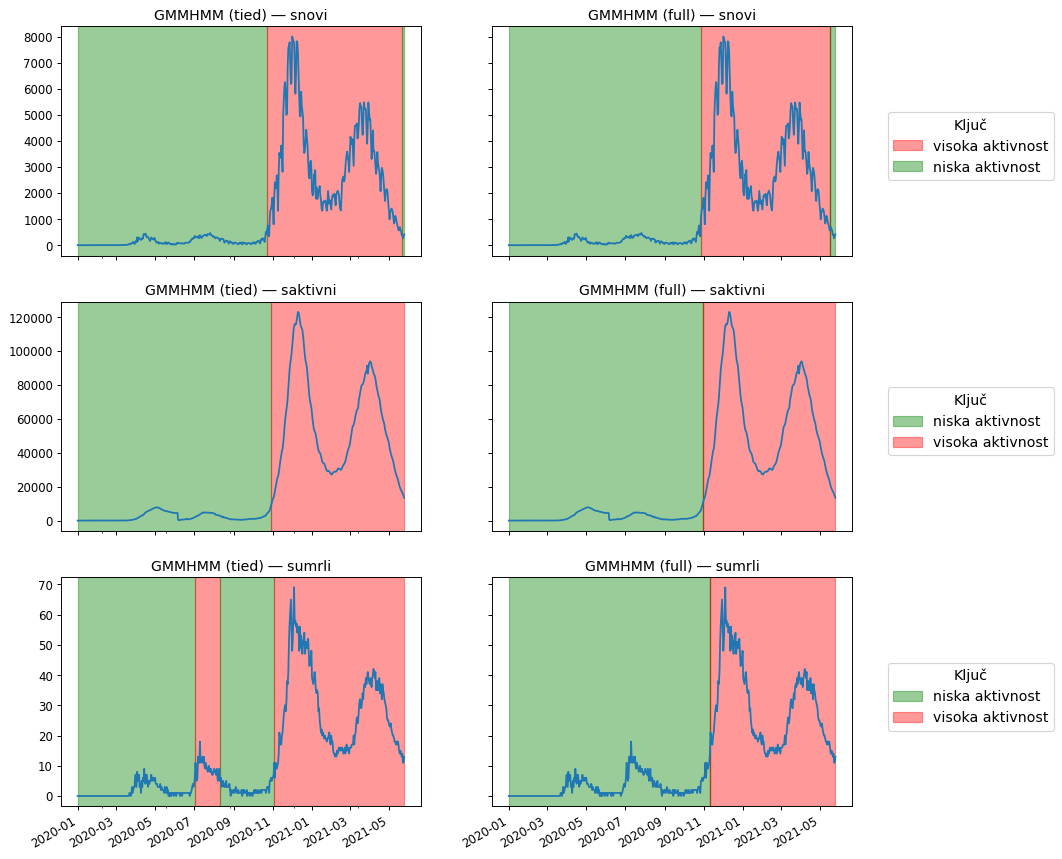

In [56]:
for i, ax in enumerate(grafici(3, 2).flatten()):
    covar = 'full' if i%2 else 'tied'
    podaci = dff.iloc[:, i//2]
    
    boje = ['r', 'g'] if i < 2 else ['g', 'r']
    oznake = ['visoka aktivnost', 'niska aktivnost'] if i < 2 \
             else ['niska aktivnost', 'visoka aktivnost']
    oznake = oznake if i%2 else []
    
    HMM(GMMHMM, n_components=2, n_mix=2, covariance_type=covar) \
       .fit(podaci).plot(podaci, boje, oznake, ax)

Nema velike razlike ni kod **multivarijantnih modela** nastalih spajanjem podataka iz Srbije sa onima iz **susednih država** Hrvatske i BiH.

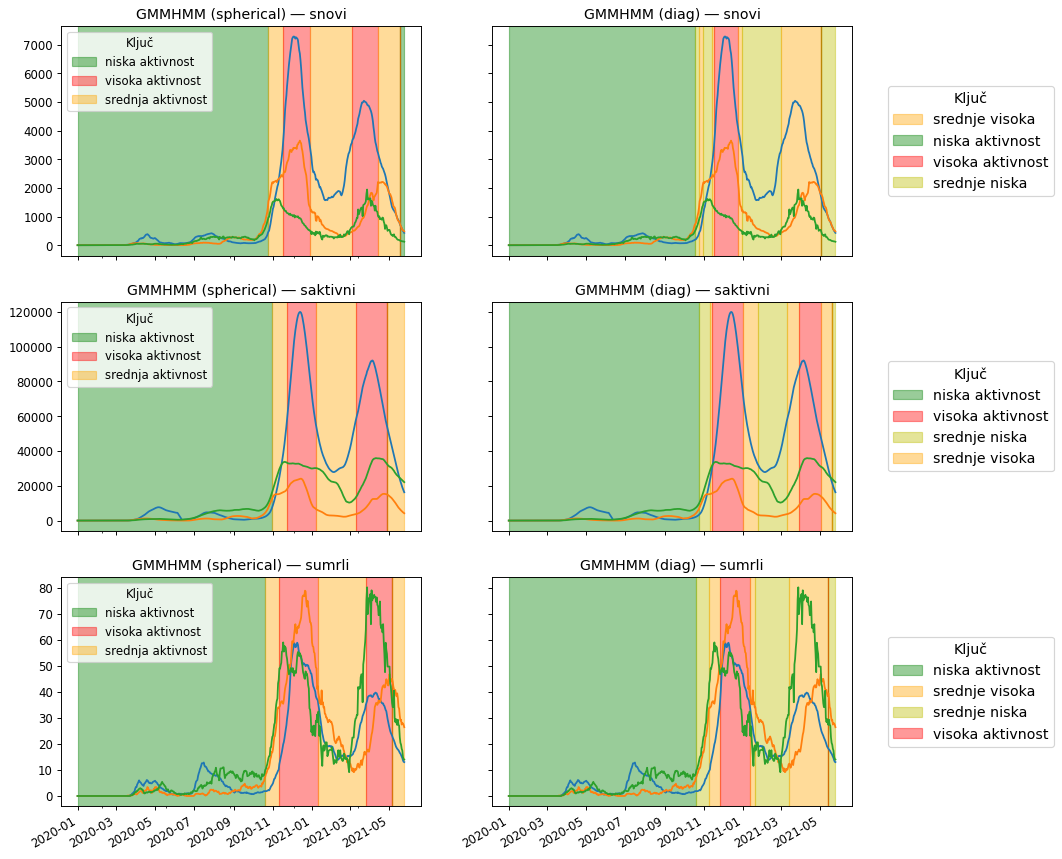

In [57]:
for i, ax in enumerate(grafici(3, 2).flatten()):
    covar = 'diag' if i%2 else 'spherical'
    
    podaci = dff.iloc[:, [i//2 + 3*j for j in range(3)]]
    podaci = podaci.rolling(7).mean().fillna(0)
    
    podaci.name = dff.columns[i//2]
    
    bojozn = {
        'g': 'niska aktivnost',
        'y': 'srednje niska',
        'orange': 'srednje visoka',
        'r': 'visoka aktivnost'
    }
    
    if not i%2:
        boje = ['g', 'r', 'orange']
        oznake = ['niska aktivnost', 'visoka aktivnost', 'srednja aktivnost']
    elif i == 1:
        boje = ['orange', 'g', 'r', 'y']
    elif i == 3:
        boje = ['g', 'r', 'y', 'orange']
    else:
        boje = ['g', 'orange', 'y', 'r']
    
    if i%2:
        oznake = [bojozn[b] for b in boje]
    
    HMM(GMMHMM, n_components=3+i%2, n_mix=5, covariance_type=covar) \
       .fit(podaci).plot(podaci, boje, oznake, ax, i%2)

Kod multivarijantnih modela koji kao pomoćne podatke koriste **pokretne proseke i odstupanja**, rezultati su drugačiji u smislu da su **optimističniji**.

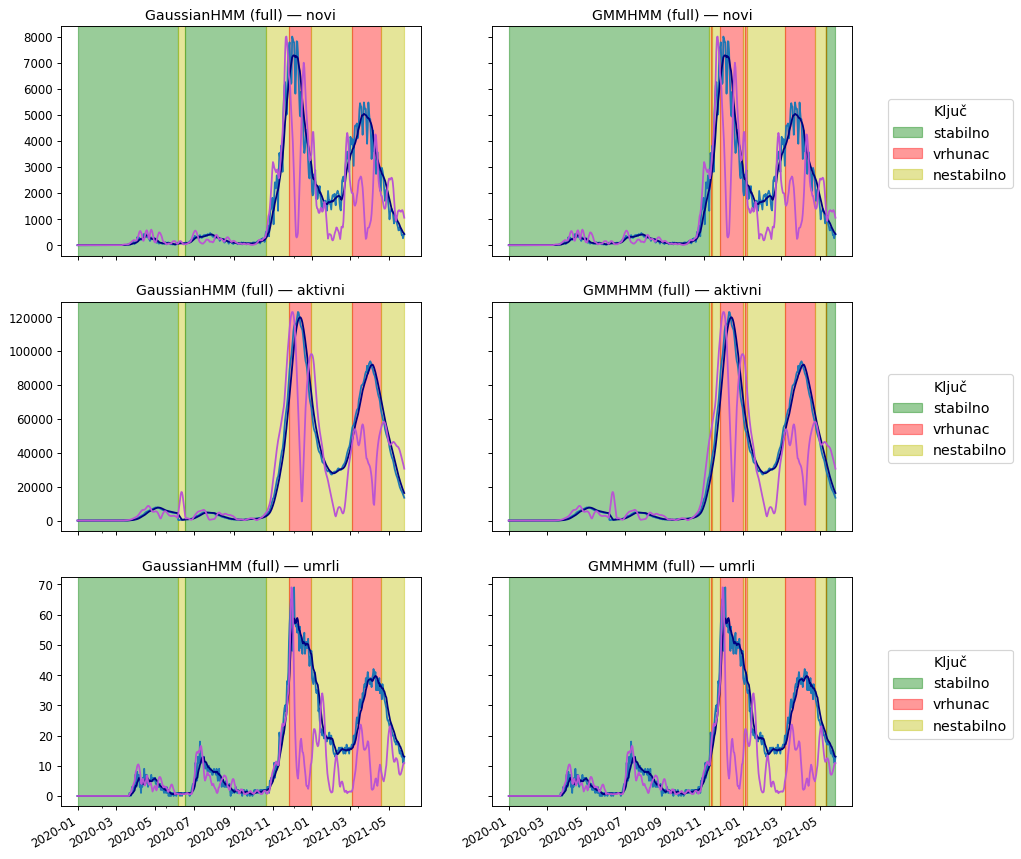

In [58]:
dfm = df.rolling(7).mean().fillna(0)
dfs = dfm.rolling(7).std().fillna(0)

dff = pd.concat((df, dfm, dfs), axis=1)

models = [HMM(GaussianHMM, n_components=3,
              covariance_type='full').fit(dff),
          HMM(GMMHMM, n_components=3, n_mix=5,
              covariance_type='full').fit(dff)]

for i, ax in enumerate(grafici(3, 2).flatten()):
    sirovi = dff.iloc[:, i//2]
    models[i%2].plot(sirovi, 3*['w'], [], ax)
    
    proseci = dff.iloc[:, i//2+3]
    models[i%2].plot(proseci, 3*['w'], [], ax, color='navy')
    
    odstupanja = dff.iloc[:, i//2+6]
    odstupanja = odstupanja / odstupanja.max()
    odstupanja = odstupanja * sirovi.max()
    models[i%2].plot(odstupanja, ['g', 'r', 'y'],
                     ['stabilno', 'vrhunac', 'nestabilno']
                     if i%2 else [], ax, color='mediumorchid')

## Dodatne ideje

Prethodna razmatranja obuhvataju samo **najosnovnije podatke o epidemiji** – brojeve zaraženih, umrlih i oporavljenih. Iako ta tri parametra jesu najvažnije odlike svake epidemije (detaljnije se može videti [ovde](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology), npr. model [SEIRD](https://github.com/paulorobertobranco/covid_seird)), postoje i mnogi drugi koji se uzimaju u obzir pri pravljenju robusnijih modela:
* **vakcinacija** – obično ubrzava završetak tekućeg talasa i sprečava nastanak narednog; na nivou skrivenog Markovljevog modela, visok stepen vakcinacije povećao bi verovatnoće prelaza u silaznu i zdravu fazu, a smanjio verovatnoće prelaza iz njih u one lošije, uzlaznu ili uporni plato,
* **broj hospitalizovanih** – (pre)opterećenost bolnica i broj pacijenata na veštačkoj ventilaciji bitan je parametar kod određivanja mera i faze epidemije,
* **udeo pozitivnih testova** – u zemljama sa široko dostupnim testiranjem, nizak udeo pozitivnih testova često označava silaznu fazu...

Ovi parametri, međutim, nisu uzeti u obzir, najviše zbog toga što ih nije bilo lako naći. Iako ih Vlada Republike Srbije objavljuje svaki dan, ne postoji zvanični repozitorijum sa svim ranijim podacima, dakle za bilo koji dan osim današnjeg, pa nije moguće odrediti celu vremensku seriju, već isključivo tekuću vrednost.

Takođe, važno je napomenuti da su **HMM suštinski nenadgledani modeli**, poput klasterovanja, pa da samim tim mogu dati nezadovoljavajuće, neočekivane ili nejasne rezultate. Stoga bi se, pored njih, mogla primeniti i nadgledana **uslovna slučajna polja**  ([CRF](https://github.com/TeamHG-Memex/sklearn-crfsuite)), koja bi uz pomoć datih oznaka (nastalih npr. ručnim labeliranjem podataka), poput klasifikatora, verovatno još bolje i detaljnije uhvatila šablon razvoja pandemije. Dobijanje dodatnih informacija moglo bi se pokušati i pomoću naprednijeg uklapanja u pretpostavljenu raspodelu (npr. [*lmfit*](https://lmfit.github.io/lmfit-py/)), pa i nekog od **regresionih modela** za određene delove (npr. [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)).

## Zaključak

U uvodnom delu rada, prodiskutovan je problem koji se rešava, što je **određivanje i predviđanje faza epidemije COVID-19 u Republici Srbiji**, nakon čega su dostupni podaci učitani, pripremljeni i vizuelizovani. Napisana je pomoćna klasa za rad sa **skrivenim Markovljevim modelima (HMM)**.

Prvi pokušaj sa **diskretnim HMM sa dva skrivena stanja** dao je model nad serijom **umrlih pacijenata** koji dobro opisuje i predviđa **nivo aktivnosti virusa**. Upotreba većeg broja stanja, razlika prvog reda i pokretnih proseka nije donela poboljšanja, a model zbog naivnosti nije upotrebljiv na drugim serijama. Dalje, upotreba **znaka razlike** umesto apsolutne vrednosti dala je dobar model aktivnosti odnosno odgovora na pitanje da li je tekuća faza **uzlazna ili silazna**. Ovaj model bio je najprecizniji na podacima o **aktivnim slučajevima**. Još precizniji i detaljniji bio je model zasnovan na **pokretnim odstupanjima**.

**Neprekidni (Gausov) HMM** takođe je dao dobre rezultate, poput detaljnije podele na **nisku, srednje nisku, srednje visoku i visoku aktivnost** nad **svim serijama**. Dodavanjem pokretnih statistika i **podataka iz regiona**, dobijeni su **multivarijantni HMM** koji uspešno razlučuju **vrhunac talasa** od ostalih delova, kao i nivo aktivnosti. **Veći broj skrivenih stanja** kod multivarijantnih HMM dao je tačnu podelu toka epidemije po **fazama**, odnosno po **talasima i pauzama**.

**Uklapanjem talasa u normalnu raspodelu** zaključeno je da postoji određenih preklapanja, pa je primenjen i **mešoviti Gausov HMM**. Većina rezultata bila je **slična** onima kod običnih Gausovih HMM, s tim što je model sa pokretnim statistikama **optimističniji**, a onaj sa podacima iz regiona nešto **pesimističniji**.

U okviru podnaslova posvećenog **dodatnim idejama**, izneto je nekoliko predloga kako za poboljšavanje trenutnih, tako za dobijanje novih rezultata.

U toku rada je pokazano i na koji način se mogu **uklopiti i analizirati postojeće i predložiti nove protivepidemijske mere**. Iako se modeli uglavnom slažu po pitanju predviđenih faza, postoje sitne nesuglasice oko **tekuće (25. maj 2021)** – uglavnom je predviđena **niska aktivnost**, odnosno **stabilno stanje**, mada postoje i nešto pesimističnije procene. Sudeći po **uklopljenoj normalnoj krivoj**, čini se da je **21. jun** u redu kao predloženi datum **ukidanja mera**.